In [1]:
import torch
from PIL import Image, ImageDraw, ImageFont
import os
import sys
import glob

# --- 로컬 Pororo 모듈 경로 설정 ---
# 이 노트북 파일(predict.ipynb)은 customOCR 폴더에 있으므로,
# pororo_main 폴더는 같은 레벨에 있다고 가정합니다.
PORORO_PATH = os.path.abspath(os.path.join(os.path.dirname('.'), '..', 'pororo_main'))
if PORORO_PATH not in sys.path:
    sys.path.append(PORORO_PATH)
    print(f"Added to sys.path: {PORORO_PATH}")

try:
    from main import PororoOcr
except ImportError:
    print(f"오류: '{PORORO_PATH}' 경로에서 Pororo 모듈을 찾을 수 없습니다.")
    print("customOCR 폴더와 같은 위치에 'pororo_main' 폴더가 있는지 확인해주세요.")
    # In a notebook, we might not want to exit, just raise the error.
    raise

from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
# config.py 파일이 src 폴더 안에 있으므로 경로를 추가해줍니다.
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), 'src')))
from config import OUTPUT_DIR, id2label, DEVICE

print("\n필요한 모듈을 모두 로드했습니다.")

Added to sys.path: c:\code\pororo_main

필요한 모듈을 모두 로드했습니다.


In [2]:
import re
import torch.nn.functional as F
from collections import defaultdict

class AdvancedDocumentPredictor:
    """
    예측 결과의 공간적/문맥적 관계를 분석하여 최종 결과를 재구성하는 지능형 예측기.
    """
    def __init__(self, model_path, confidence_threshold=0.85):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 경로를 찾을 수 없습니다: {model_path}")
        
        print("모델과 프로세서를 로딩합니다...")
        self.processor = LayoutLMv3Processor.from_pretrained(model_path)
        self.model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
        self.model.to(DEVICE)
        self.model.eval()
        
        print("OCR 엔진(Local Pororo)을 초기화합니다...")
        self.ocr_reader = PororoOcr()
        self.confidence_threshold = confidence_threshold
        print(f"설정된 신뢰도 임계값: {self.confidence_threshold}")

    def _split_semantic_units(self, ocr_words, ocr_boxes):
        """[문제 3 해결] '출금/입금'과 '잔액'이 합쳐진 텍스트와 박스를 분할합니다."""
        new_words, new_boxes = [], []
        pattern = re.compile(r'^(출금|입금)\s*([\d,.-]+)\s*원?\s*(잔액)\s*([\d,.-]+)\s*원?$')
        for word, box in zip(ocr_words, ocr_boxes):
            match = pattern.match(word)
            if match:
                amount_text = f"{match.group(1)} {match.group(2)}"
                balance_text = f"{match.group(3)} {match.group(4)}"
                x1, y1, x2, y2 = box
                width = x2 - x1
                split_ratio = len(amount_text) / (len(amount_text) + len(balance_text) + 1)
                split_point = x1 + int(width * split_ratio)
                new_words.extend([amount_text, balance_text])
                new_boxes.extend([[x1, y1, split_point, y2], [split_point, y1, x2, y2]])
            else:
                new_words.append(word)
                new_boxes.append(box)
        return new_words, new_boxes

    def predict(self, image_path):
        """OCR 및 정보 추출 파이프라인을 실행합니다."""
        print(f"\n'{os.path.basename(image_path)}' 처리 시작...")
        original_image = Image.open(image_path).convert("RGB")
        
        temp_image_path = "temp_image_for_ocr.png"
        original_image.save(temp_image_path)
        self.ocr_reader.run_ocr(temp_image_path, debug=False)
        ocr_results = self.ocr_reader.get_ocr_result()
        os.remove(temp_image_path)

        if not ocr_results or not ocr_results.get('description'):
            return [], original_image

        raw_words_initial = ocr_results['description']
        raw_boxes_initial = []
        for poly in ocr_results['bounding_poly']:
            vertices = poly.get('vertices', [])
            if not vertices: continue
            x_coords = [p['x'] for p in vertices]
            y_coords = [p['y'] for p in vertices]
            raw_boxes_initial.append([min(x_coords), min(y_coords), max(x_coords), max(y_coords)])

        words, raw_boxes = self._split_semantic_units(raw_words_initial, raw_boxes_initial)

        width, height = original_image.size
        boxes = [[int(1000 * b[0] / width), int(1000 * b[1] / height), int(1000 * b[2] / width), int(1000 * b[3] / height)] for b in raw_boxes]

        encoding = self.processor(original_image, words, boxes=boxes, return_tensors="pt", padding="max_length", truncation=True).to(DEVICE)
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        probabilities = F.softmax(outputs.logits, dim=-1).squeeze()
        predictions = torch.argmax(probabilities, dim=-1)
        max_probs = torch.max(probabilities, dim=-1).values
        
        results = self._advanced_postprocess(encoding, predictions.tolist(), max_probs.tolist(), words, raw_boxes)
        return results, original_image

    def _advanced_postprocess(self, encoding, predictions, probabilities, words, raw_boxes):
        """
        모델 예측 결과를 기반으로 공간적, 문맥적 관계를 분석하여 최종 결과를 재구성하는 핵심 함수.
        """
        word_ids = encoding.word_ids(0)
        
        # 1. 신뢰도 기반 초기 예측 결과 생성
        initial_preds = []
        for idx, (pred_id, prob) in enumerate(zip(predictions, probabilities)):
            word_idx = word_ids[idx]
            if word_idx is None or (idx > 0 and word_idx == word_ids[idx-1]):
                continue
            
            label = id2label[pred_id]
            if prob >= self.confidence_threshold and label != 'O':
                initial_preds.append({
                    "text": words[word_idx], "label": label, "box": raw_boxes[word_idx],
                    "confidence": prob, "word_idx": word_idx
                })

        if not initial_preds: return []

        # 2. [문제 4 해결] 수직으로 인접한 동일 라벨 병합 (신협 UI 케이스)
        # y 좌표 기준으로 정렬
        initial_preds.sort(key=lambda p: (p['box'][1], p['box'][0]))
        merged_vertical = []
        used_indices = set()
        for i in range(len(initial_preds)):
            if i in used_indices: continue
            current_pred = initial_preds[i]
            for j in range(i + 1, len(initial_preds)):
                if j in used_indices: continue
                next_pred = initial_preds[j]
                # 라벨이 같고, 수직으로 가까우며, 수평으로 겹칠 때
                if current_pred['label'] == next_pred['label'] and \
                   abs(current_pred['box'][0] - next_pred['box'][0]) < 50 and \
                   (next_pred['box'][1] - current_pred['box'][3]) < 20:
                    current_pred['text'] += " " + next_pred['text']
                    current_pred['box'][2] = max(current_pred['box'][2], next_pred['box'][2])
                    current_pred['box'][3] = next_pred['box'][3]
                    used_indices.add(j)
            merged_vertical.append(current_pred)
            used_indices.add(i)

        # 3. [문제 2 해결] 키워드 기반 라벨 보정 (더 엄격한 규칙 적용)
        corrected_preds = []
        for pred in merged_vertical:
            text = pred['text']
            # 숫자와 특정 기호만 있을 때만 AMOUNT로 간주
            is_numeric = bool(re.fullmatch(r'[\d,.-]+원?', text.replace(" ", "")))

            if is_numeric:
                if '-' in text: pred['label'] = 'AMOUNT_OUT'
                # '+'나 '입금' 키워드가 없으면, 모델의 예측(색상/위치 기반)을 존중
            elif '잔액' in text:
                pred['label'] = 'BALANCE'
            
            corrected_preds.append(pred)

        # 4. [문제 1 해결] 거래 단위로 그룹화 및 재구성
        # y 좌표(세로 위치)를 기준으로 거래 라인을 그룹화
        transactions = defaultdict(list)
        for pred in corrected_preds:
            # 박스의 세로 중앙값을 기준으로 그룹화 키 생성
            y_center = pred['box'][1] + (pred['box'][3] - pred['box'][1]) / 2
            group_key = int(y_center // 40) # 40픽셀 높이를 하나의 라인으로 간주
            transactions[group_key].append(pred)

        final_results = []
        for _, items in sorted(transactions.items()):
            # 각 라인 내에서 x 좌표(가로 위치)로 정렬
            items.sort(key=lambda p: p['box'][0])
            final_results.extend(items)

        # 최종 신뢰도 포맷팅
        for pred in final_results:
            pred['confidence'] = f"{pred['confidence']:.2f}"
            
        return final_results

print("AdvancedDocumentPredictor 클래스가 로드되었습니다.")

AdvancedDocumentPredictor 클래스가 로드되었습니다.


In [3]:
def draw_predictions(image, predictions, font_path=None):
    """예측 결과를 원본 이미지 위에 시각화합니다. (신뢰도 표시 및 색상 개선)"""
    draw = ImageDraw.Draw(image)
    
    try:
        font = ImageFont.truetype(font_path or "malgun.ttf", size=15)
    except IOError:
        print("경고: 'malgun.ttf' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()

    # ★★★ 시인성 좋은 색상으로 변경 ★★★
    label_colors = {
        "DATE_HEADER": "#ff7f0e", # 주황
        "DATE": "#1f77b4",       # 파랑
        "TIME": "#d62728",       # 빨강
        "MERCHANT": "#2ca02c",   # 초록
        "MEMO": "#9467bd",       # 보라
        "AMOUNT_IN": "#8c564b",  # 갈색
        "AMOUNT_OUT": "#e377c2", # 핑크
        "BALANCE": "#7f7f7f",    # 회색
    }

    for pred in predictions:
        box = pred['box']
        label = pred['label']
        color = label_colors.get(label, "#bcbd22") # 기본값: 올리브색
        
        draw.rectangle(box, outline=color, width=3)
        
        # ★★★ 라벨 텍스트에 신뢰도 점수 추가 ★★★
        label_text = f"{label} ({pred['confidence']})"
        
        text_bbox = draw.textbbox((box[0], box[1]), label_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        label_bg_box = [box[0], box[1] - text_height - 6, box[0] + text_width + 8, box[1]]
        draw.rectangle(label_bg_box, fill=color)
        
        draw.text((box[0] + 4, box[1] - text_height - 4), label_text, fill="white", font=font)
        
    return image

print("draw_predictions 함수가 신뢰도 표시 기능과 새로운 색상 구성으로 업데이트되었습니다.")

draw_predictions 함수가 신뢰도 표시 기능과 새로운 색상 구성으로 업데이트되었습니다.


모델과 프로세서를 로딩합니다...
OCR 엔진(Local Pororo)을 초기화합니다...
설정된 신뢰도 임계값: 0.85

'KakaoTalk_20250624_075429567.png' 처리 시작...

--- [KakaoTalk_20250624_075429567.png] 정보 추출 결과 ---


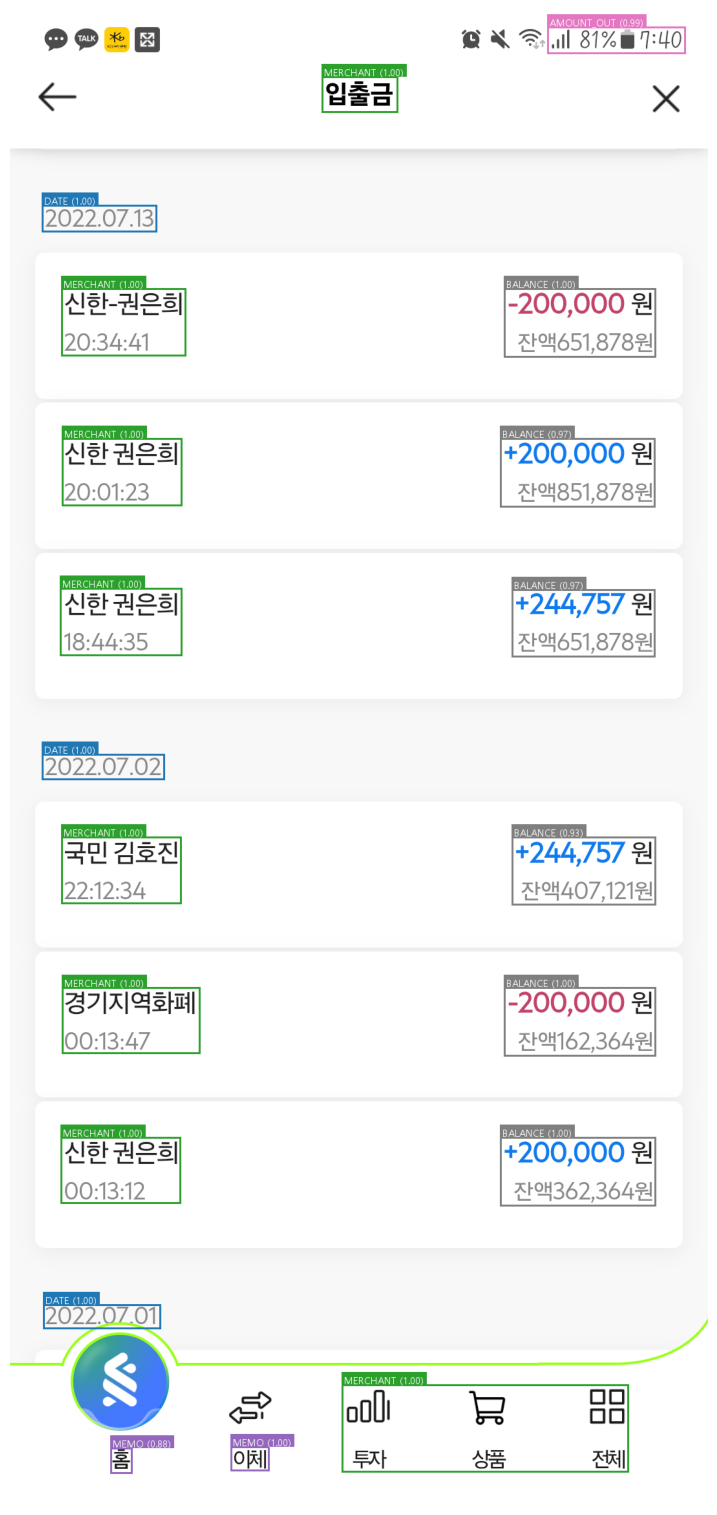


[텍스트 요약]
- AMOUNT_OUT: .1| 81% 7:40
- MERCHANT: 입출금, 신한-권은희 20.34:41, 신한 권은희 20.01:23, 신한 권은희 18.44:35, 국민 김호진 22:12:34, 경기지역화폐 00:13:47, 신한 권은희 00:13:12, oo@i 감금 투자 상품 전체'
- DATE: 2022.07.13, 2022.07.02, 2022,07.01
- BALANCE: -200,000 원 잔액651,878원, +200,000 원 잔액851,878원, +244,757 원 잔액651,878원, +244,757 원 잔액407,121원, -200,000 원 잔액162,364원, +200,000 원 잔액362,364원
- MEMO: 홈홈, 이체
--------------------------------------------------

'sanup1.jpg' 처리 시작...

--- [sanup1.jpg] 정보 추출 결과 ---


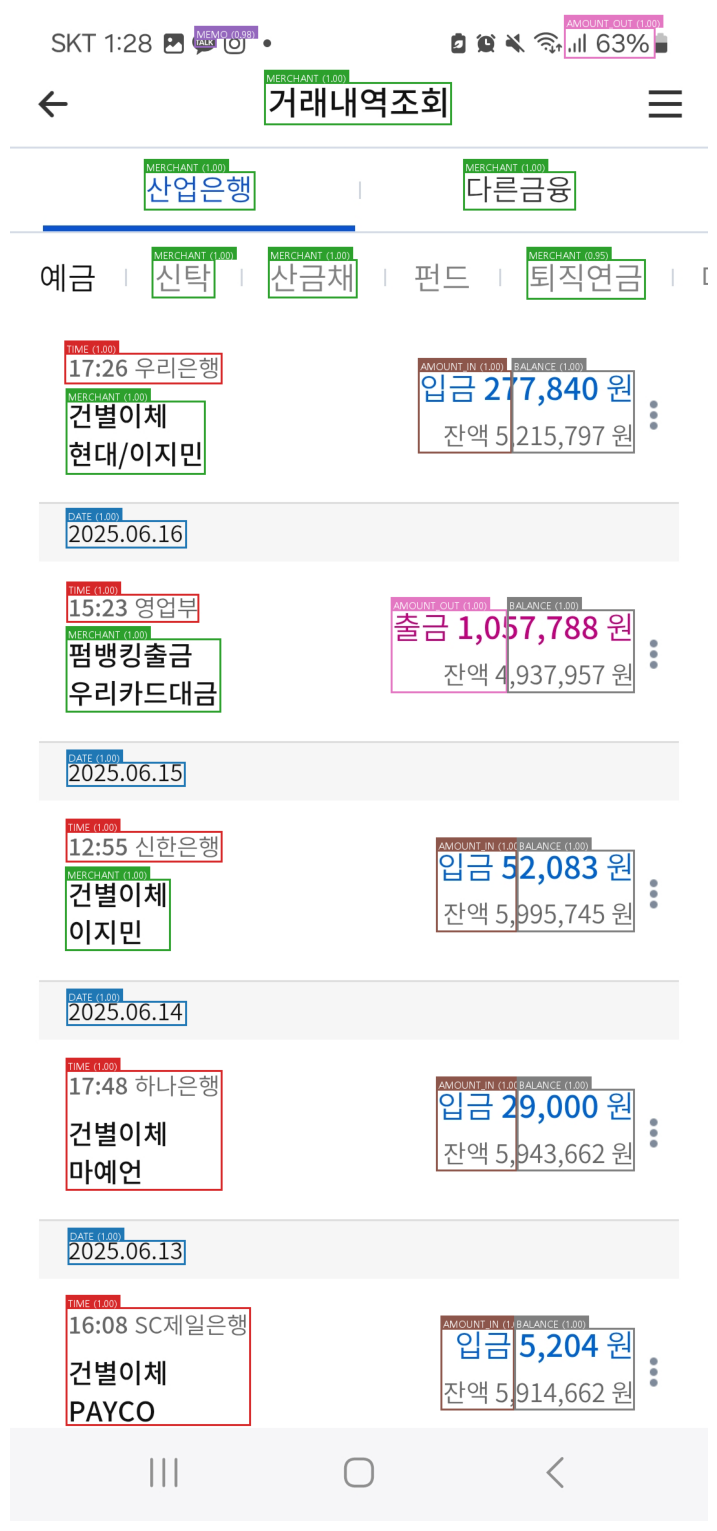


[텍스트 요약]
- MEMO: TALK'
- AMOUNT_OUT: -1l| 63%, 출금 1,057,788
- MERCHANT: 거래내역조회, 산업은행, 다른금융, 신탁, 산금채, 퇴직연금, 건별이체 현대)이지민, 펌뱅킹출금 우리카드대금, 건별이체 이지민
- TIME: 17:26 우리은행, 15:23 영업부, 12:55 신한은행, 17:48 하나은행 건별이체 마예언, 16:08 SC제일은행 건별이체 PAYCO
- AMOUNT_IN: 입금 277,840, 입금 52,083, 입금 29,000, 입금 5,204
- BALANCE: 잔액 5,215,797, 잔액 4,937,957, 잔액 5,995,745, 잔액 5,943,662, 잔액 5,914,662
- DATE: 2025.06.16, 2025.06.15, 2025.06.14, 2025.06.13
--------------------------------------------------

'sanup2.jpg' 처리 시작...

--- [sanup2.jpg] 정보 추출 결과 ---


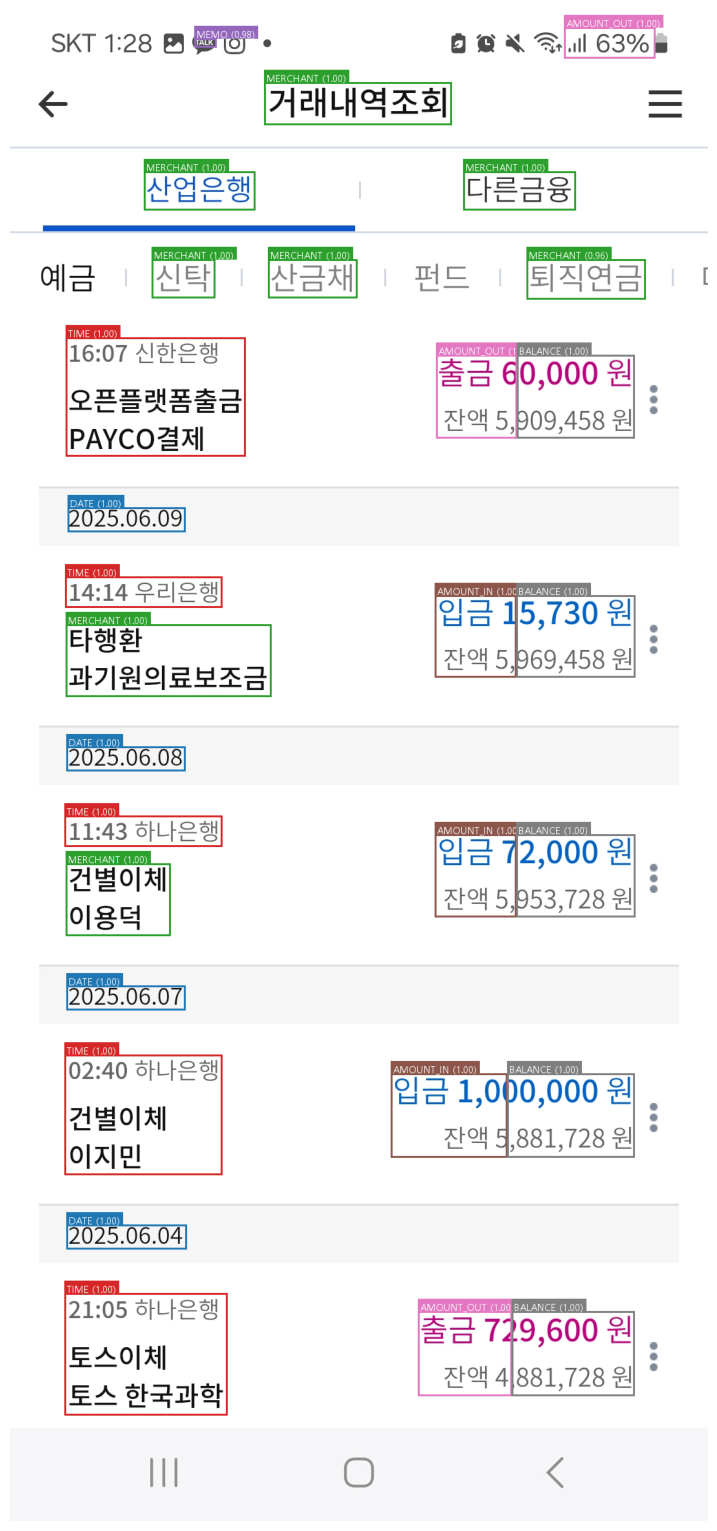


[텍스트 요약]
- MEMO: TALK'
- AMOUNT_OUT: -1l| 63%, 출금 60,000, 출금 729,600
- MERCHANT: 거래내역조회, 산업은행, 다른금융, 신탁, 산금채, 퇴직연금, 타행환 과기원의료보조금, 건별이체 이용덕
- BALANCE: 잔액 5,909,458, 잔액 5,969,458, 잔액 5,953,728, 잔액 5,881,728, 잔액 4,881,728
- TIME: 16:07 신한은행 오픈플랫폼출금 PAYCO결제, 14:14 우리은행, 11:43 하나은행, 02:40 하나은행 건별이체 이지민, 21:05 하나은행 토스이체 토스 한국과학
- DATE: 2025.06.09, 2025.06.08, 2025.06.07, 2025.06.04
- AMOUNT_IN: 입금 15,730, 입금 72,000, 입금 1,000,000
--------------------------------------------------

'sanup3.jpg' 처리 시작...

--- [sanup3.jpg] 정보 추출 결과 ---


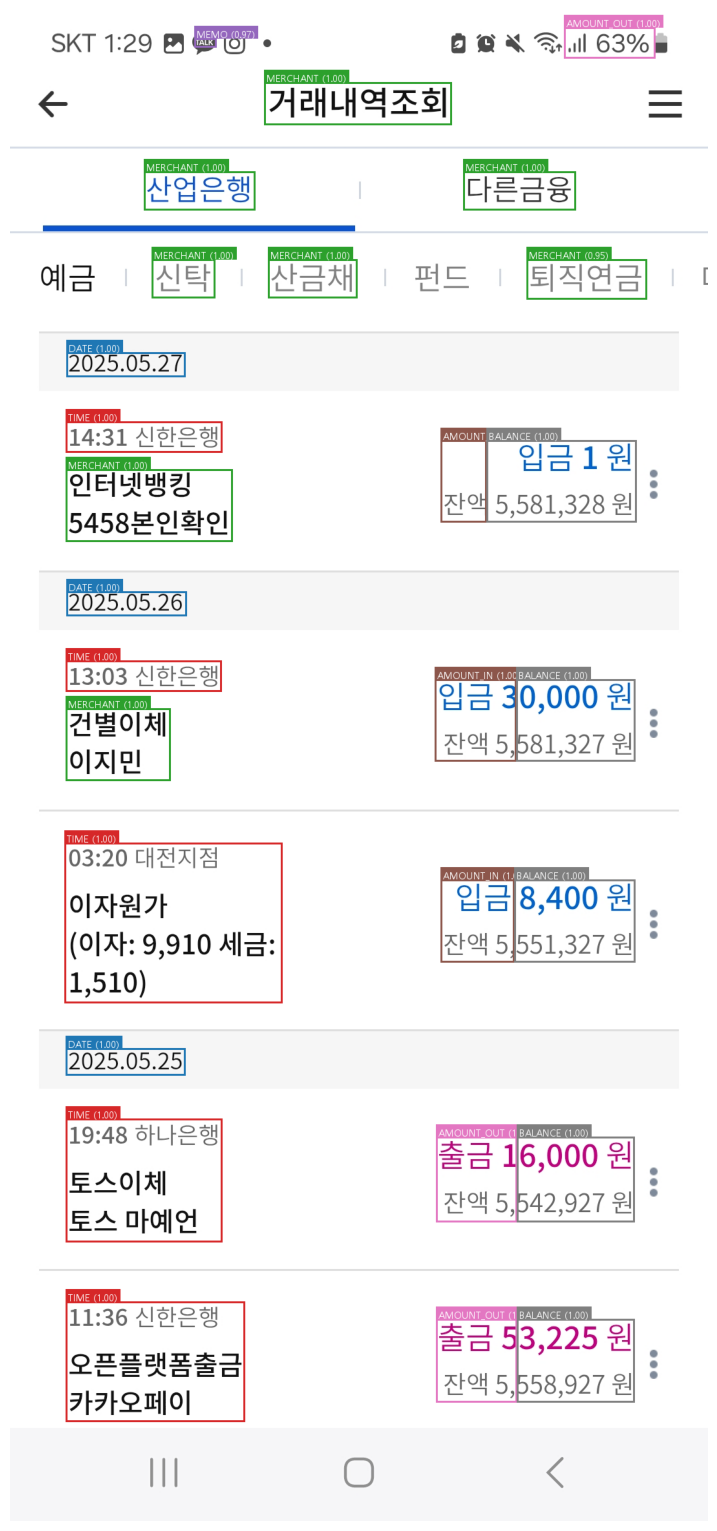


[텍스트 요약]
- MEMO: TALK'
- AMOUNT_OUT: -1l| 63%, 출금 16,000, 출금 53,225
- MERCHANT: 거래내역조회, 산업은행, 다른금융, 신탁, 산금채, 퇴직연금, 인터넷뱅킹 5458본인확인, 건별이체 이지민
- DATE: 2025.05.27, 2025.05.26, 2025.05.25
- TIME: 14:31 신한은행, 13:03 신한은행, 03:20 대전지점 이자원가 (이자: 9,910 세금: 1,510), 19:48 하나은행 토스이체 토스 마예언, 11:36 신한은행 오픈플랫폼출금 카카오페이
- AMOUNT_IN: 입금 1, 입금 30,000, 입금 8,400
- BALANCE: 잔액 5,581,328, 잔액 5,581,327, 잔액 5,551,327, 잔액 5,542,927, 잔액 5,558,927
--------------------------------------------------

'sanup4.jpg' 처리 시작...

--- [sanup4.jpg] 정보 추출 결과 ---


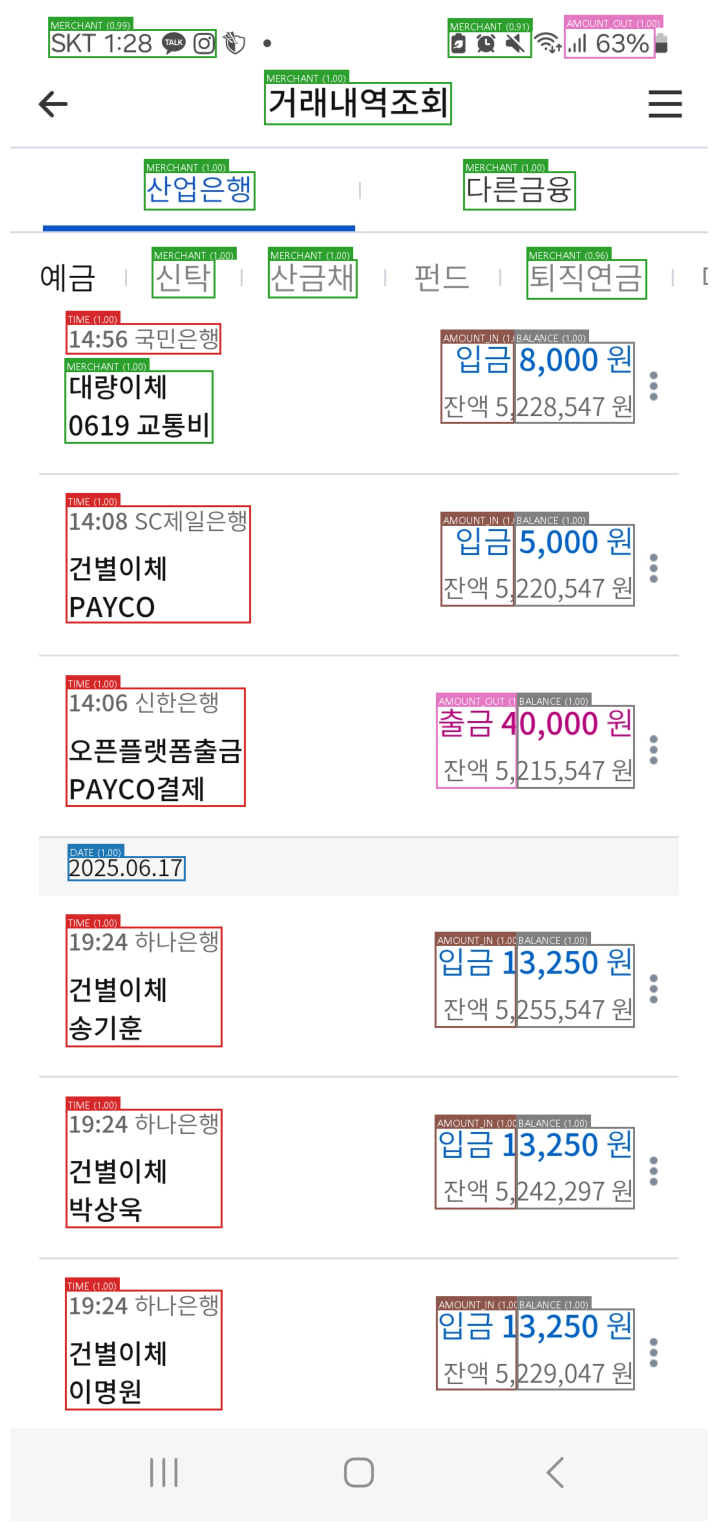


[텍스트 요약]
- MERCHANT: SKT 1:28 TALK @, @**, 거래내역조회, 산업은행, 다른금융, 신탁, 산금채, 퇴직연금, 대량이체 0619 교통비
- AMOUNT_OUT: -1l| 63%, 출금 40,000
- TIME: 14:56 국민은행, 14:08 SC제일은행 건별이체 PAYCO, 14:06 신한은행 오픈플랫폼출금 PAYCO결제, 19:24 하나은행 건별이체 송기훈, 19:24 하나은행 건별이체 박상욱, 19:24 하나은행 건별이체 이명원
- AMOUNT_IN: 입금 8,000, 입금 5,000, 입금 13,250, 입금 13,250, 입금 13,250
- BALANCE: 잔액 5,228,547, 잔액 5,220,547, 잔액 5,215,547, 잔액 5,255,547, 잔액 5,242,297, 잔액 5,229,047
- DATE: 2025.06.17
--------------------------------------------------

'kookmin1.png' 처리 시작...

--- [kookmin1.png] 정보 추출 결과 ---


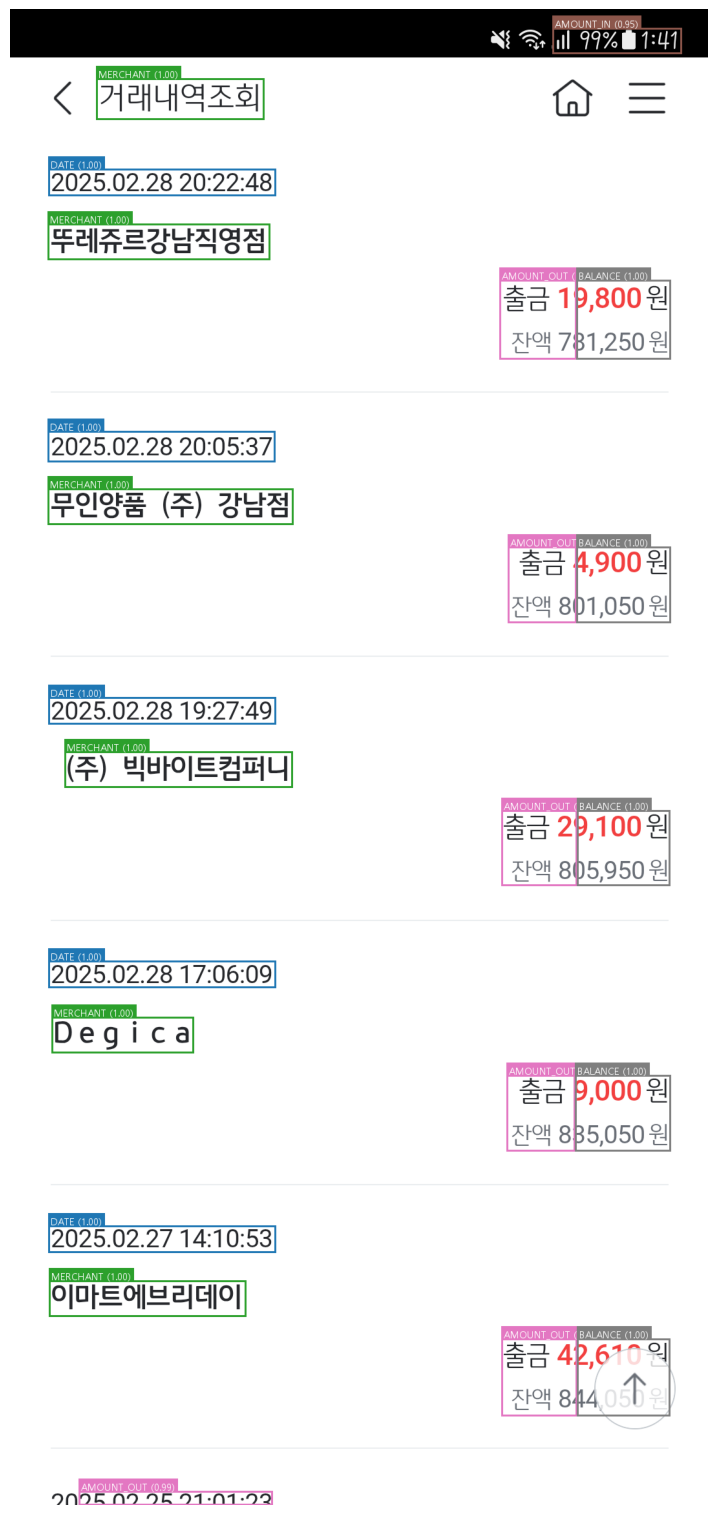


[텍스트 요약]
- AMOUNT_IN: | 99% 1:41
- MERCHANT: 거래내역조회, 뚜레쥬르강남직영점, 무인양품 (주) 강남점, (주) 빅바이트컴퍼니, Degica, 이마트에브리데이
- DATE: 2025.02.28 20:22:48, 2025.02.28 20:05:37, 2025.02.28 19:27:49, 2025.02.28 17:06:09, 2025.02.27 14:10:53
- AMOUNT_OUT: 출금 19,800, 출금 4,900, 출금 29,100, 출금 9,000, 출금 42,610, 75 07 75 71.01-72
- BALANCE: 잔액 781,250, 잔액 801,050, 잔액 805,950, 잔액 835,050, 잔액 844,056
--------------------------------------------------

'kookmin2.png' 처리 시작...

--- [kookmin2.png] 정보 추출 결과 ---


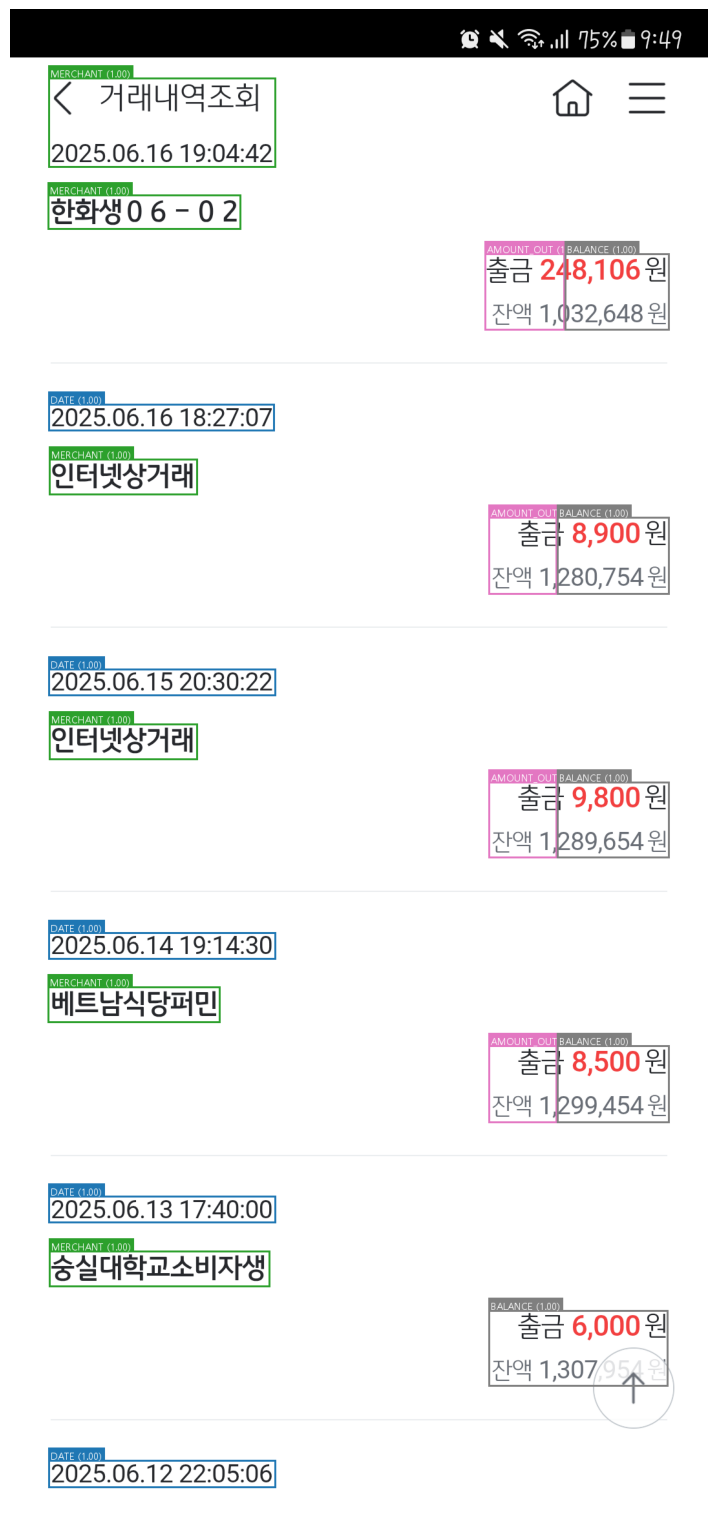


[텍스트 요약]
- MERCHANT: 거래내역조회 2025.06.16 19:04:42, 한화생 0 6 - 0 2, 인터넷상거래, 인터넷상거래, 베트남식당퍼민, 숭실대학교소비자생
- AMOUNT_OUT: 출금 248,106, 출금 8,900, 출금 9,800, 출금 8,500
- BALANCE: 잔액 1,032,648, 잔액 1,280,754, 잔액 1,289,654, 잔액 1,299,454, 출금 6,000원 잔액 1,307(95m
- DATE: 2025.06.16 18:27:07, 2025.06.15 20:30:22, 2025.06.14 19:14:30, 2025.06.13 17:40:00, 2025.06.12 22:05:06
--------------------------------------------------

'kookmin3.png' 처리 시작...

--- [kookmin3.png] 정보 추출 결과 ---


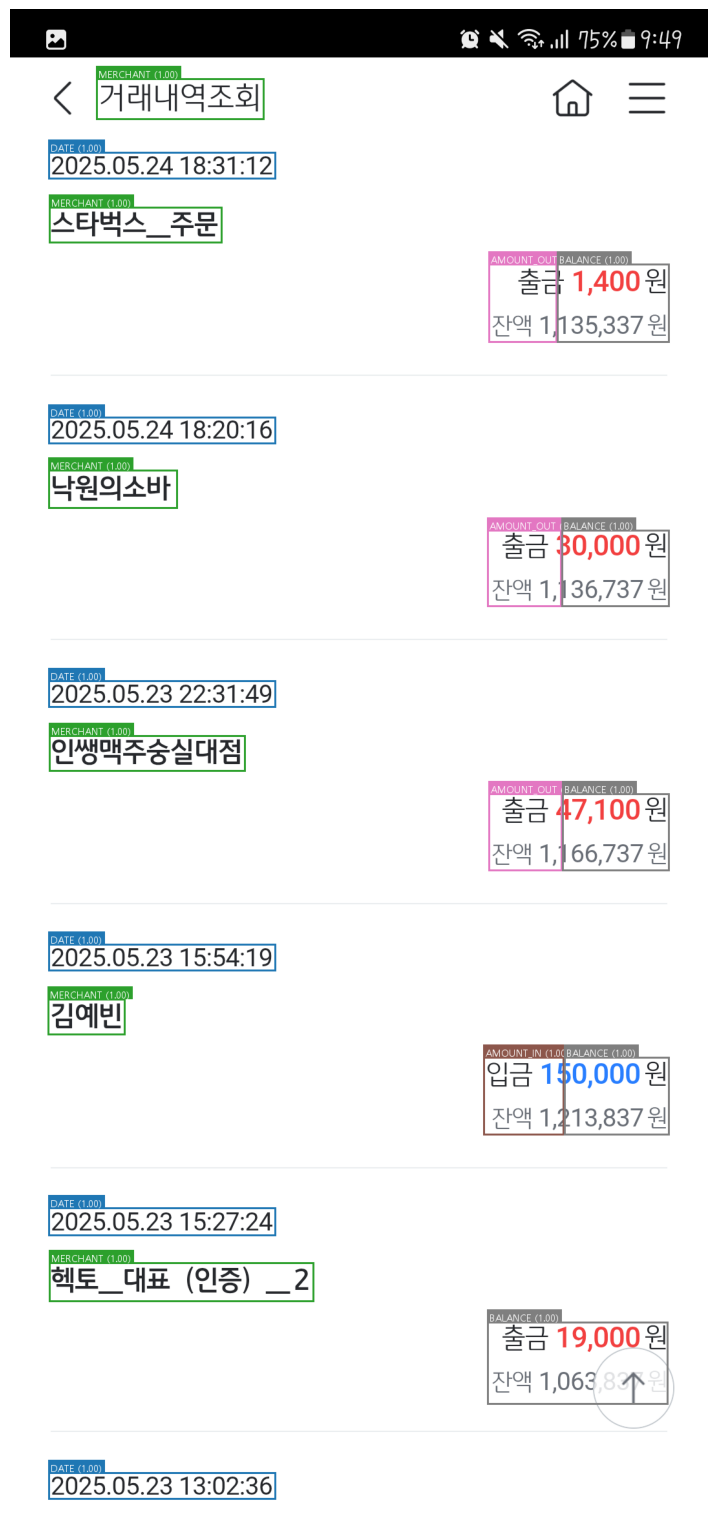


[텍스트 요약]
- MERCHANT: 거래내역조회, 스타벅스 주문, 낙원의소바, 인쌩맥주숭실대점, 김예빈, 헥토. 대표 (인증) -2
- DATE: 2025.05.24 18:31:12, 2025.05.24 18:20:16, 2025.05.23 22:31:49, 2025.05.23 15:54:19, 2025.05.23 15:27:24, 2025.05.23 13:02:36
- AMOUNT_OUT: 출금 1,400, 출금 30,000, 출금 47,100
- BALANCE: 잔액 1,135,337, 잔액 1,136,737, 잔액 1,166,737, 잔액 1,213,837, 출금 19,000원 잔액 1,063's > 원ㄴ
- AMOUNT_IN: 입금 150,000
--------------------------------------------------

'kookmin4.png' 처리 시작...

--- [kookmin4.png] 정보 추출 결과 ---


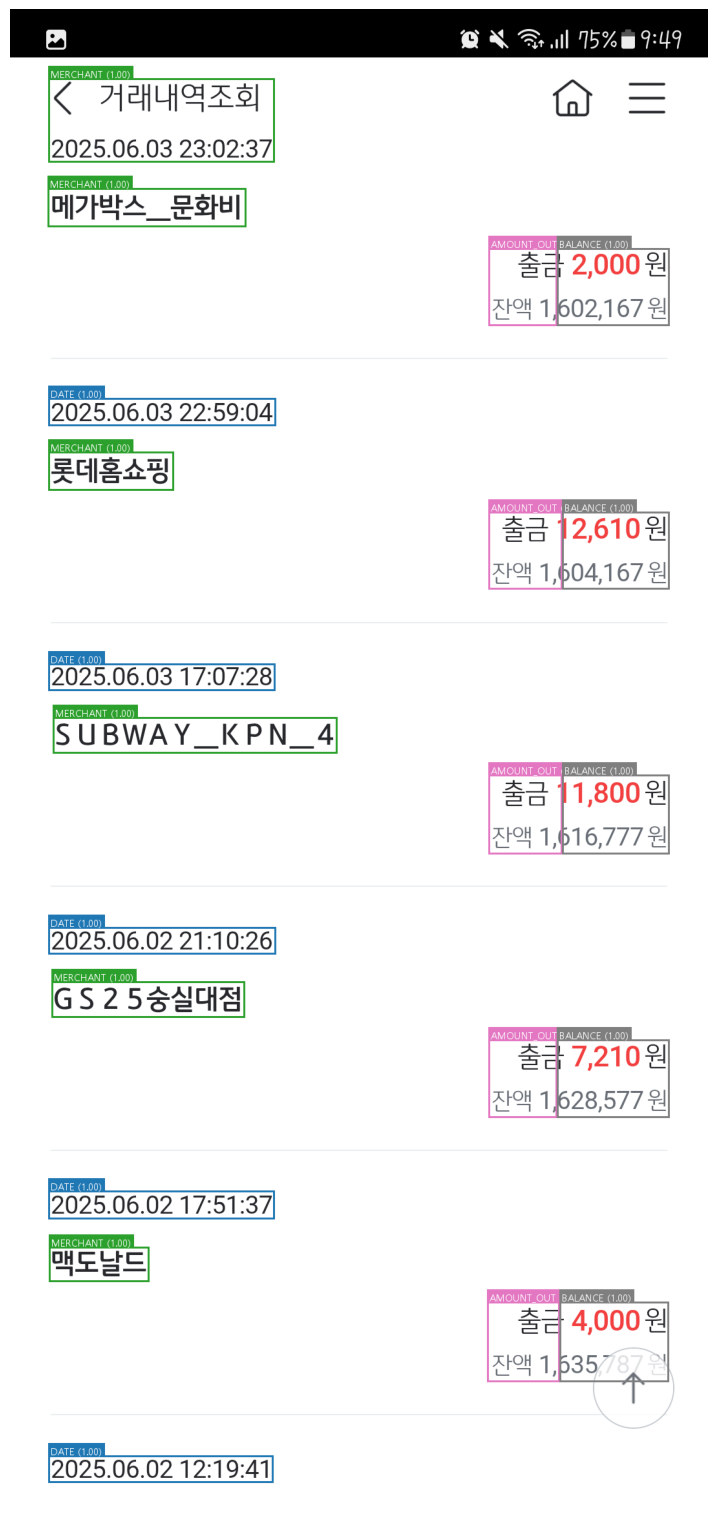


[텍스트 요약]
- MERCHANT: 거래내역조회 2025.06.03 23:02:37, 문화비, 롯데홈쇼핑, 4, G S 2 5숭실대점, 맥도날드
- AMOUNT_OUT: 출금 2,000, 출금 12,610, 출금 11,800, 출금 7,210, 출금 4,000
- BALANCE: 잔액 1,602,167, 잔액 1,604,167, 잔액 1,616,777, 잔액 1,628,577, 잔액 1,635787
- DATE: 2025.06.03 22:59:04, 2025.06.03 17:07:28, 2025.06.02 21:10:26, 2025.06.02 17:51:37, 2025.06.02 12:19:41
--------------------------------------------------

'shinhan1.png' 처리 시작...

--- [shinhan1.png] 정보 추출 결과 ---


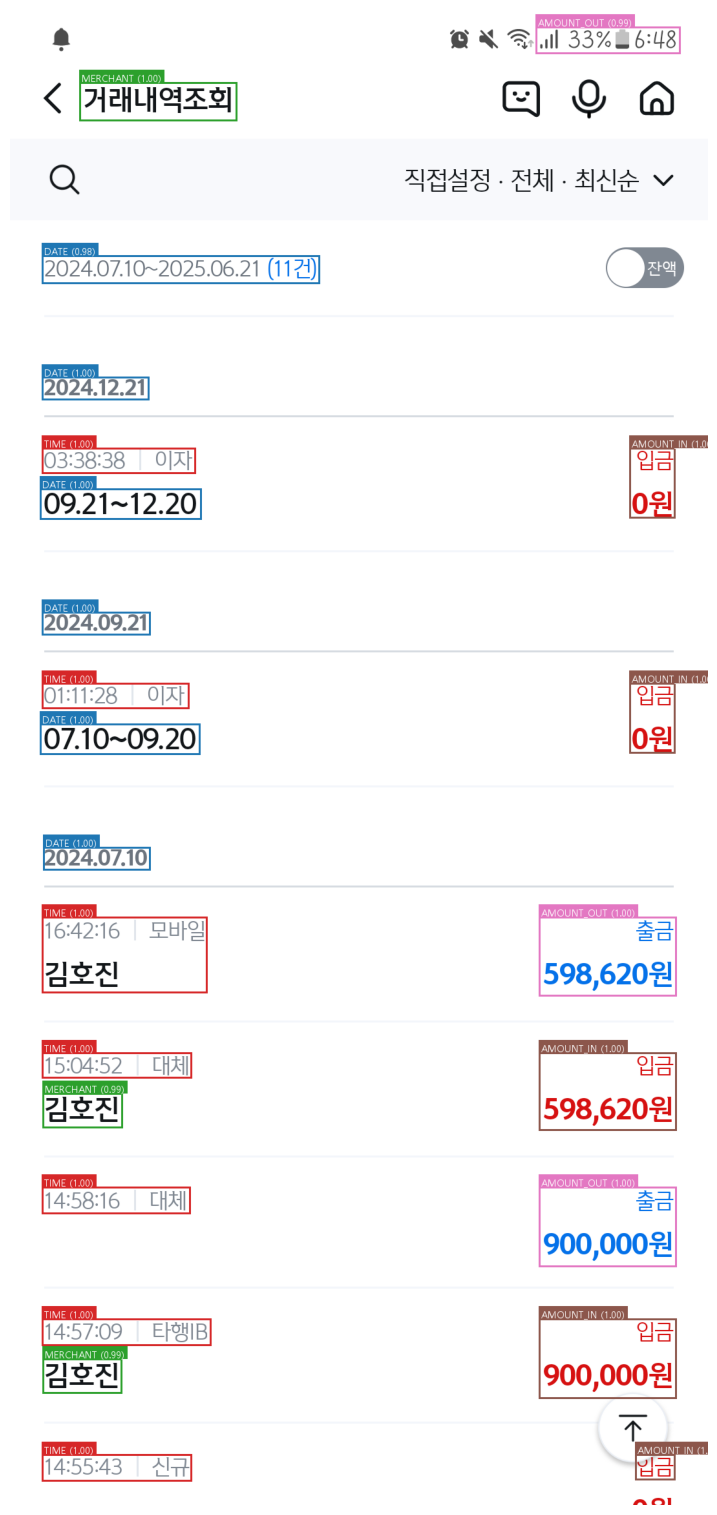


[텍스트 요약]
- AMOUNT_OUT: .l| 33% 6:48, 출금 598,620원, 출금 900,000원
- MERCHANT: 거래내역조회, 김호진, 김호진
- DATE: 2024.07.10~2025.06.21 (11건), 2024.12.21, 09.21~12.20, 2024.09.21, 07.10~09.20, 2024.07.10
- TIME: 03:38:38 이자, 01:11:28 이자, 16:42:16 모바일 김호진, 15:04:52 대체, 14:58:16 대체, 14:57:09 타행IB, 14:55:43 신규
- AMOUNT_IN: 입금 0원, 입금 0원, 입금 598,620원, 입금 900,000원, 입금
--------------------------------------------------

'shinhyup.png' 처리 시작...

--- [shinhyup.png] 정보 추출 결과 ---


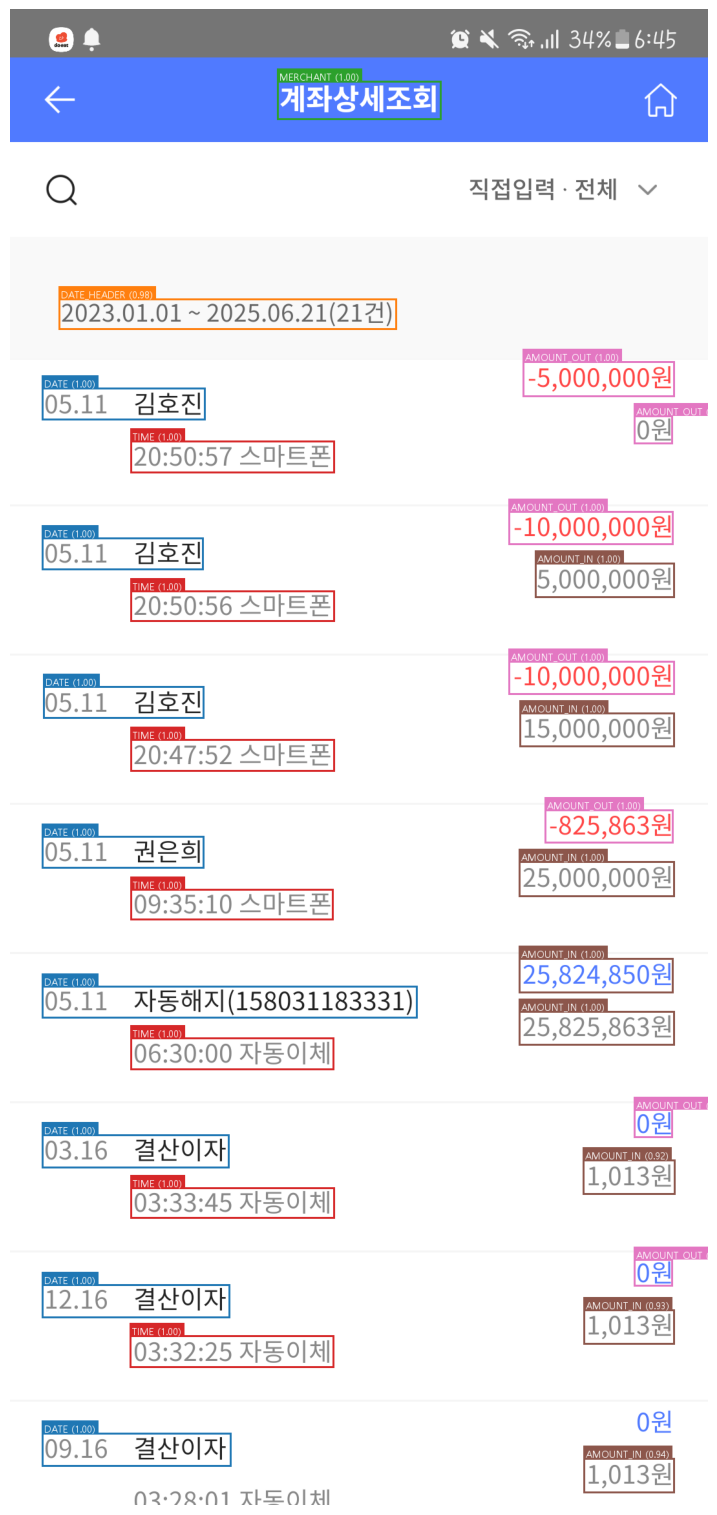


[텍스트 요약]
- MERCHANT: 계좌상세조회
- DATE_HEADER: 2023.01.01 2025.06.21(21건)
- AMOUNT_OUT: -5,000,000원, 0원, -10,000,000원, -10,000,000원, -825,863원, 0원, 0원
- DATE: 05.11 김호진, 05.11 김호진, 05.11 김호진, 05.11 권은희, 05.11 자동해지(158031183331), 03.16 결산이자, 12.16 결산이자, 09.16 결산이자
- TIME: 20:50:57 스마트폰, 20:50:56 스마트폰, 20:47:52 스마트폰, 09:35:10 스마트폰, 06:30:00 자동이체, 03:33:45 자동이체, 03:32:25 자동이체
- AMOUNT_IN: 5,000,000원, 15,000,000원, 25,000,000원, 25,824,850원, 25,825,863원, 1,013원, 1,013원, 1,013원
--------------------------------------------------

'toss1.png' 처리 시작...

--- [toss1.png] 정보 추출 결과 ---


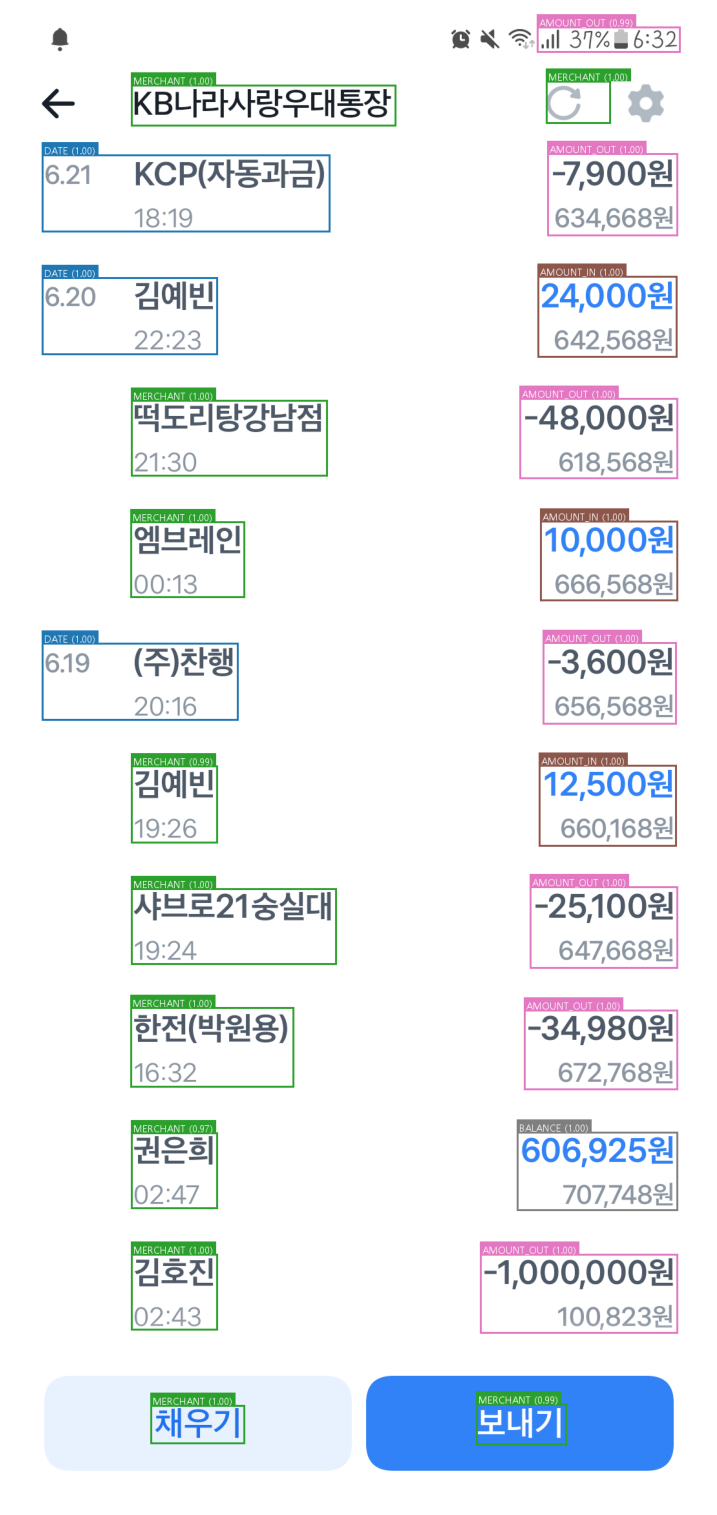


[텍스트 요약]
- AMOUNT_OUT: .l| 37% 6:32, -7,900원 634,668원, -48,000원 618,568원, -3,600원 656,568원, -25,100원 647,668원, -34,980원 672,768원, -1,000,000원 100,823원
- MERCHANT: KB나라사랑우대통장, C, 떡도리탕강남점 21:30, 엠브레인 00:13, 김예빈 19:26, 샤브로21숭실대 19:24, 한전(박원용) 16:32, 권은희 02:47, 김호진 02:43, 채우기, 보내기
- DATE: 6.21 KCP(자동과금) 18:19, 6.20 김예빈 22:23, 6.19 (주)찬행 20:16
- AMOUNT_IN: 24,000원 642,568원, 10,000원 666,568원, 12,500원 660,168원
- BALANCE: 606,925원 707,748원
--------------------------------------------------

'toss2.png' 처리 시작...

--- [toss2.png] 정보 추출 결과 ---


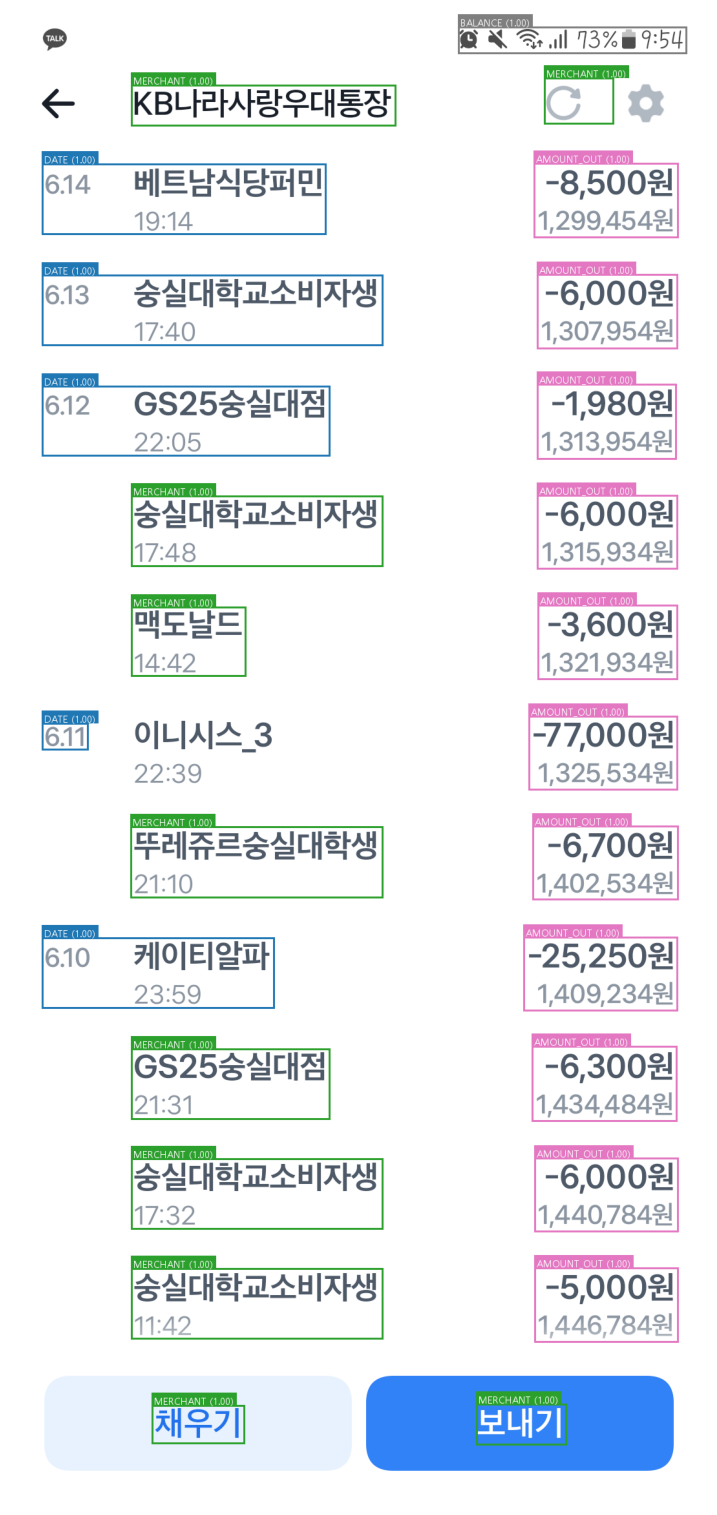


[텍스트 요약]
- BALANCE: QQ 낮 @..l 73% 9:54
- MERCHANT: KB나라사랑우대통장, C, 숭실대학교소비자생 17:48, 맥도날드 14:42, 뚜레쥬르숭실대학생 21:10, GS25숭실대점 21:31, 숭실대학교소비자생 17:32, 숭실대학교소비자생 11:42, 채우기, 보내기
- DATE: 6.14 베트남식당퍼민 19:14, 6.13 숭실대학교소비자생 17:40, 6.12 GS25숭실대점 22:05, 6.11, 6.10 케이티알파 23:59
- AMOUNT_OUT: -8,500원 1,299,454원, -6,000원 1,307,954원, -1,980원 1,313,954원, -6,000원 1,315,934원, -3,600원 1,321,934원, -77,000원 1,325,534원, -6,700원 1,402,534원, -25,250원 1,409,234원, -6,300원 1,434,484원, -6,000원 1,440,784원, -5,000원 1,446,784원
--------------------------------------------------

'toss3.png' 처리 시작...

--- [toss3.png] 정보 추출 결과 ---


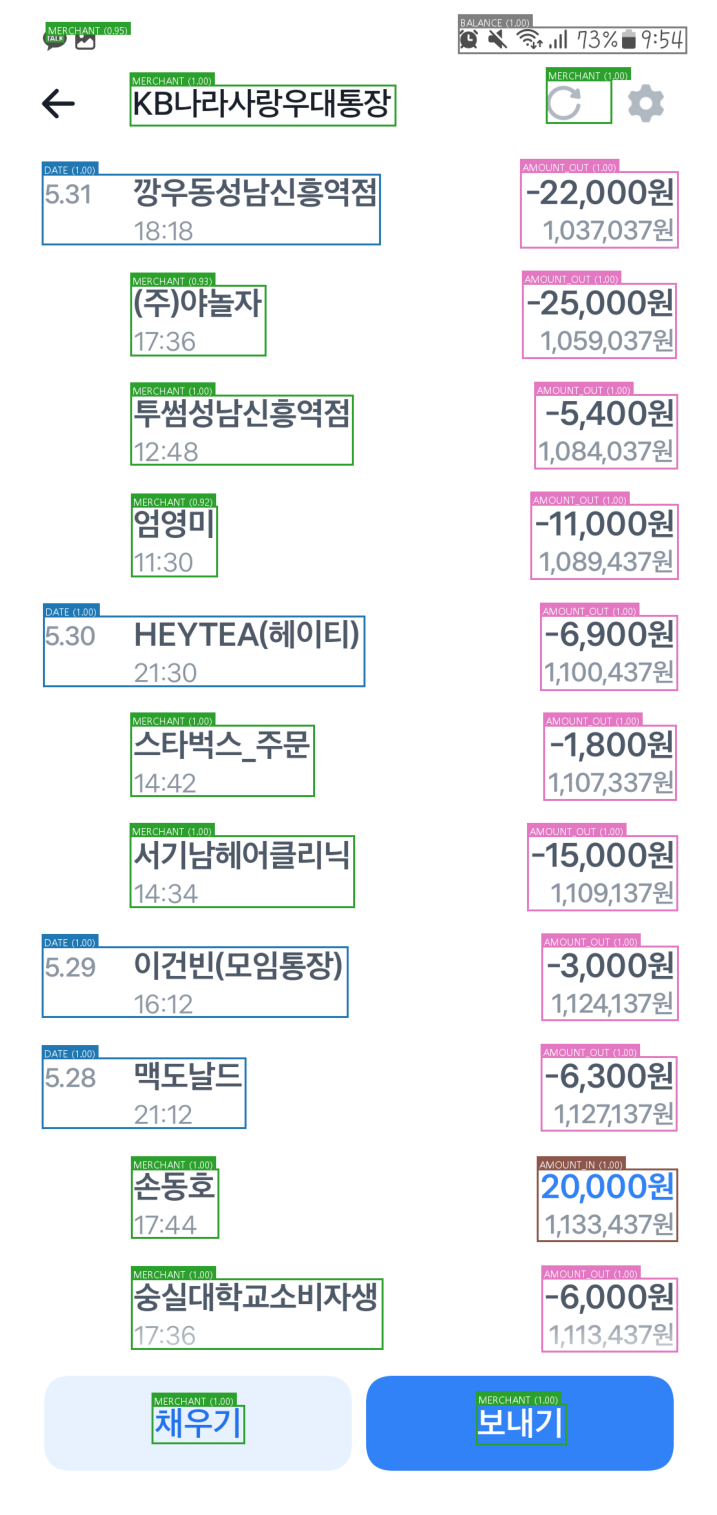


[텍스트 요약]
- MERCHANT: TALK, KB나라사랑우대통장, C, (주)야놀자 17:36, 투썸성남신흥역점 12:48, 엄영미 11:30, 주문 14:42, 서기남헤어클리닉 14:34, 손동호 17:44, 숭실대학교소비자생 17:36, 채우기, 보내기
- BALANCE: QQ 낮 @..l 73% 9:54
- DATE: 5.31 깡우동성남신흥역점 18:18, 5.30 HEYTEA(헤이티) 21:30, 5.29 이건빈(모임통장) 16:12, 5.28 맥도날드 21:12
- AMOUNT_OUT: -22,000원 1,037,037원, -25,000원 1,059,037원, -5,400원 1,084,037원, -11,000원 1,089,437원, -6,900원 1,100,437원, -1,800원 1,107,337원, -15,000원 1,109,137원, -3,000원 1,124,137원, -6,300원 1,127137원, -6,000원 1,113,437원
- AMOUNT_IN: 20,000원 1,133,437원
--------------------------------------------------

'toss4.png' 처리 시작...

--- [toss4.png] 정보 추출 결과 ---


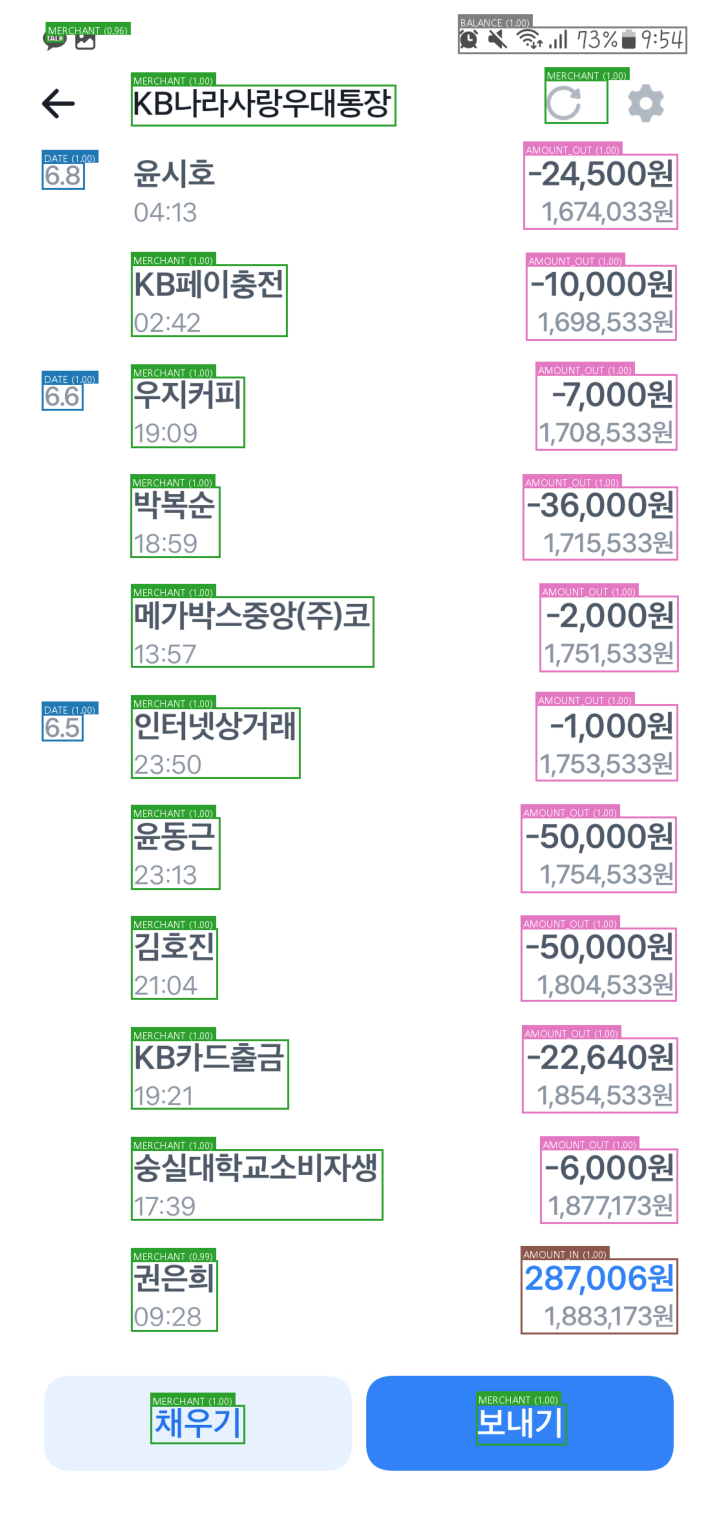


[텍스트 요약]
- MERCHANT: TALK, KB나라사랑우대통장, C, KB페이충전 02:42, 우지커피 19:09, 박복순 18:59, 메가박스중앙(주)코 13:57, 인터넷상거래 23:50, 윤동근 23:13, 김호진 21:04, KB카드출금 19:21, 숭실대학교소비자생 17:39, 권은희 09:28, 채우기, 보내기
- BALANCE: QQ 낮 @..l 73% 9:54
- DATE: 6.8, 6.6, 6.5
- AMOUNT_OUT: -24,500원 1,674,033원, -10,000원 1,698,533원, -7,000원 1,708,533원, -36,000원 1,715,533원, -2,000원 1,751,533원, -1,000원 1,753,533원, -50,000원 1,754,533원, -50,000원 1,804,533원, -22,640원 1,854,533원, -6,000원 1,877,173원
- AMOUNT_IN: 287,006원 1,883,173원
--------------------------------------------------

'woori1.png' 처리 시작...

--- [woori1.png] 정보 추출 결과 ---


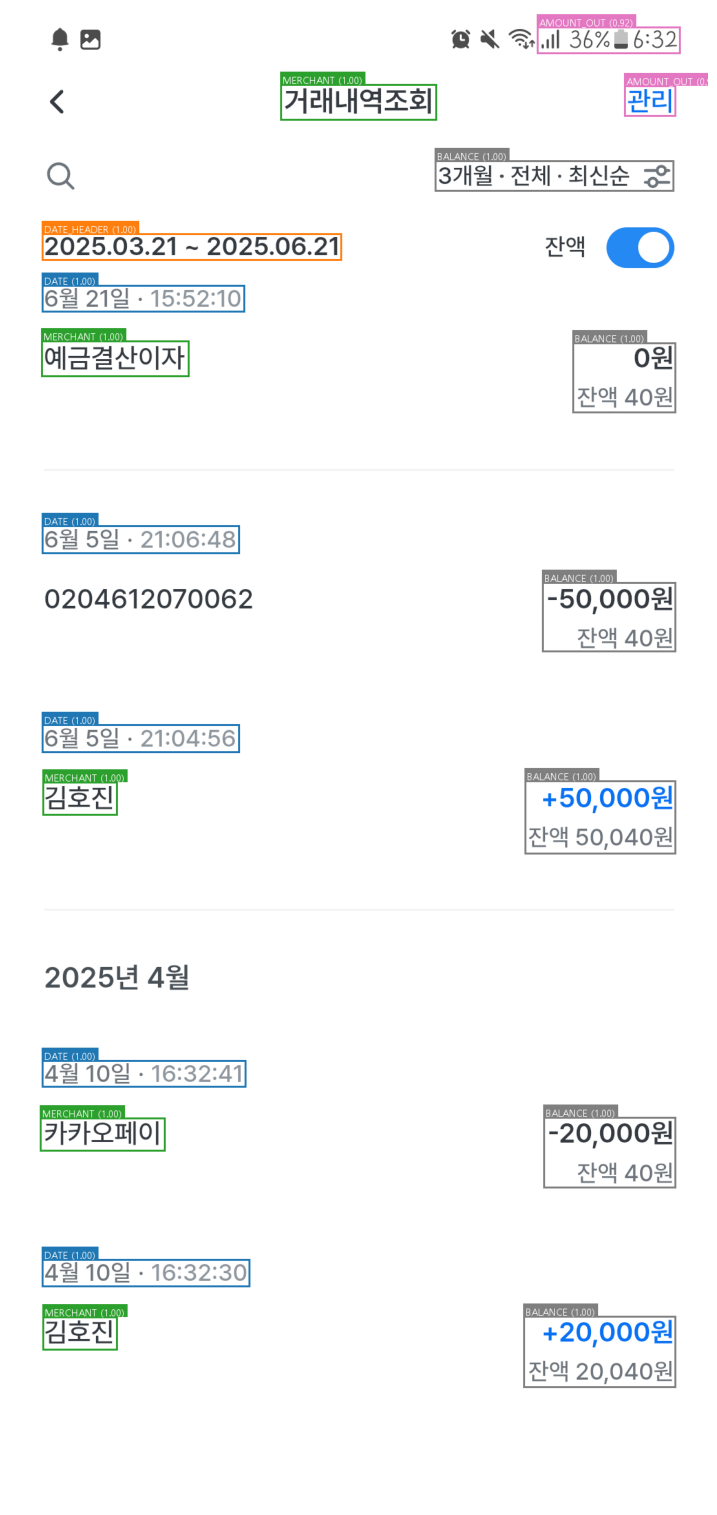


[텍스트 요약]
- AMOUNT_OUT: .11 36% 6:32, 관리
- MERCHANT: 거래내역조회, 예금결산이자, 김호진, 카카오페이, 김호진
- BALANCE: 3개월 전체 최신순 값, 0원 잔액 40원, -50,000원 잔액 40원, +50,000원 잔액 50,040원, -20,000원 잔액 40원, +20,000원 잔액 20,040원
- DATE_HEADER: 2025.03.21 2025.06.21
- DATE: 6월 21일 15:52:10, 6월 5일 21:06:48, 6월 5일 21:04:56, 4월 10일 16:32:41, 4월 10일 16:32:30
--------------------------------------------------

'woori2.png' 처리 시작...

--- [woori2.png] 정보 추출 결과 ---


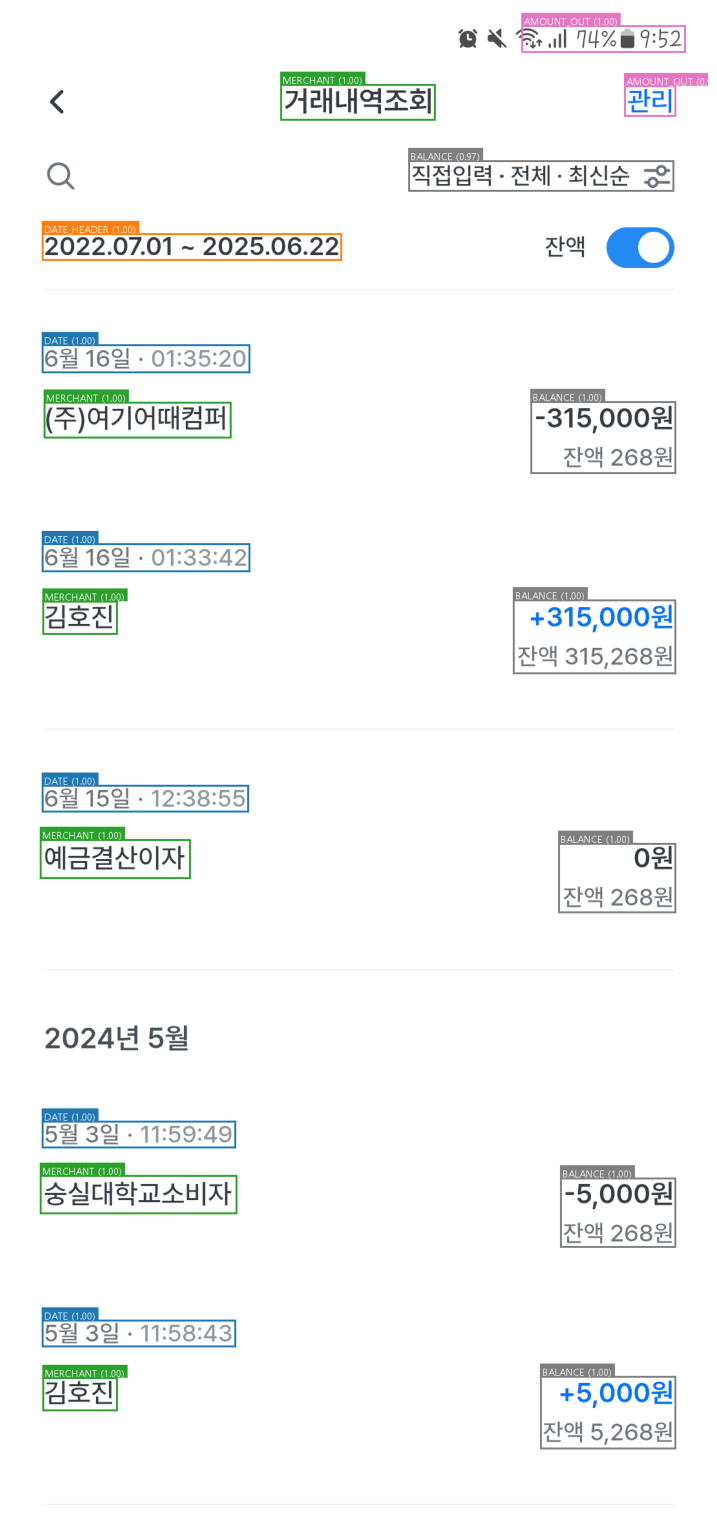


[텍스트 요약]
- AMOUNT_OUT: ~.i1| 74% 9:52, 관리
- MERCHANT: 거래내역조회, (주)여기어때컴퍼, 김호진, 예금결산이자, 숭실대학교소비자, 김호진
- BALANCE: 직접입력 전체 최신순 값, -315,000원 잔액 268원, +315,000원 잔액 315,268원, 0원 잔액 268원, -5,000원 잔액 268원, +5,000원 잔액 5,268원
- DATE_HEADER: 2022.07.01 2025.06.22
- DATE: 6월 16일 01:35:20, 6월 16일 01:33:42, 6월 15일 12:38:55, 5월 3일 11:59:49, 5월 3일 11:58:43
--------------------------------------------------

'woori3.png' 처리 시작...

--- [woori3.png] 정보 추출 결과 ---


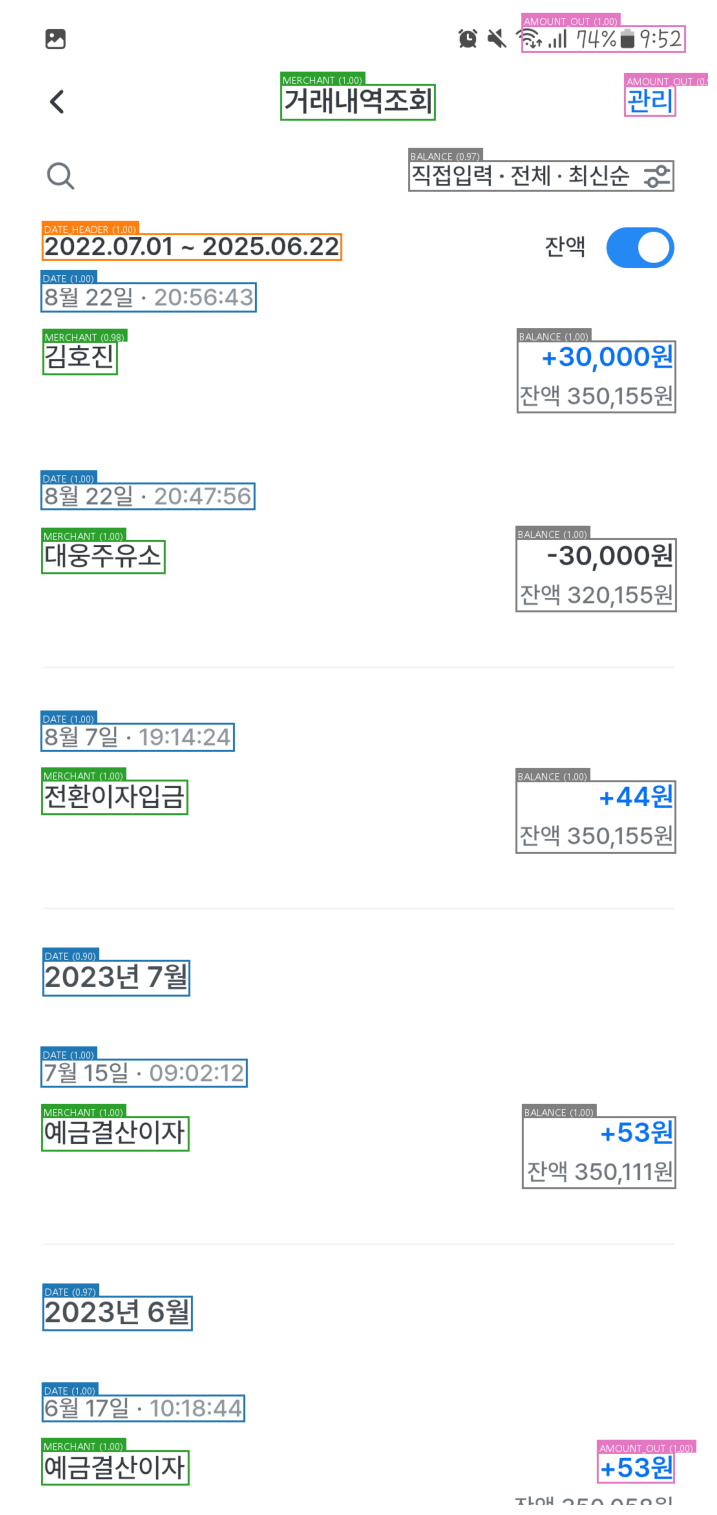


[텍스트 요약]
- AMOUNT_OUT: ~.i1| 74% 9:52, 관리, +53원
- MERCHANT: 거래내역조회, 김호진, 대웅주유소, 전환이자입금, 예금결산이자, 예금결산이자
- BALANCE: 직접입력 전체 최신순 값, +30,000원 잔액 350,155원, -30,000원 잔액 320,155원, +44원 잔액 350,155원, +53원 잔액 350,111원
- DATE_HEADER: 2022.07.01 2025.06.22
- DATE: 8월 22일 20:56:43, 8월 22일 20:47:56, 8월 7일 19:14:24, 2023년 7월, 7월 15일 09:02:12, 2023년 6월, 6월 17일 10:18:44
--------------------------------------------------

'woori4.png' 처리 시작...

--- [woori4.png] 정보 추출 결과 ---


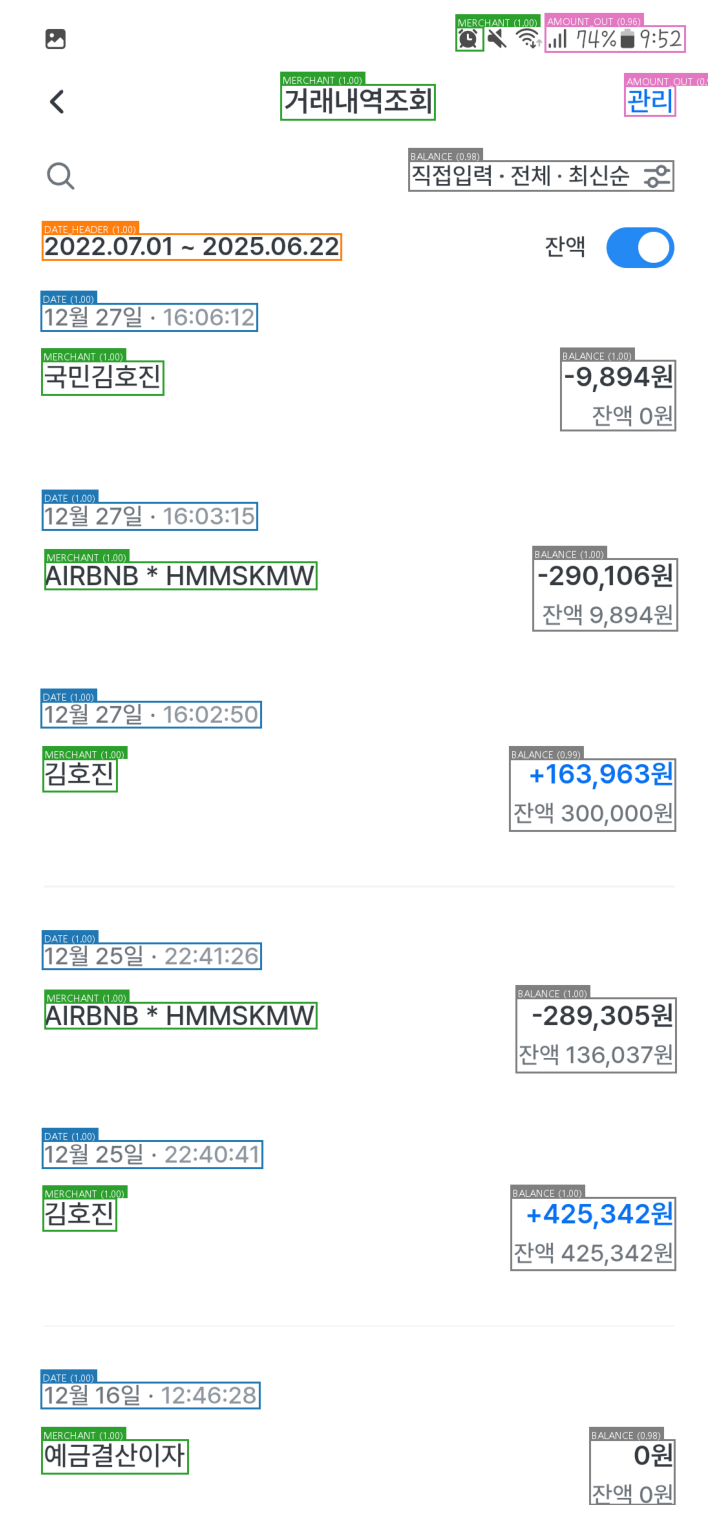


[텍스트 요약]
- MERCHANT: C, 거래내역조회, 국민김호진, AIRBNB * HMMSKMW, 김호진, AIRBNB * HMMSKMW, 김호진, 예금결산이자
- AMOUNT_OUT: .l| 74% 9:52, 관리
- BALANCE: 직접입력 전체 최신순 값, -9,894원 잔액 0원, -290,106원 잔액 9,894원, +163,963원 잔액 300,000원, -289,305원 잔액 136,037원, +425,342원 잔액 425,342원, 0원 잔액 0원
- DATE_HEADER: 2022.07.01 ~ 2025.06.22
- DATE: 12월 27일 16:06:12, 12월 27일 16:03:15, 12월 27일 16:02:50, 12월 25일 22:41:26, 12월 25일 22:40:41, 12월 16일 12:46:28
--------------------------------------------------

'bank_statement_long.jpg' 처리 시작...

--- [bank_statement_long.jpg] 정보 추출 결과 ---


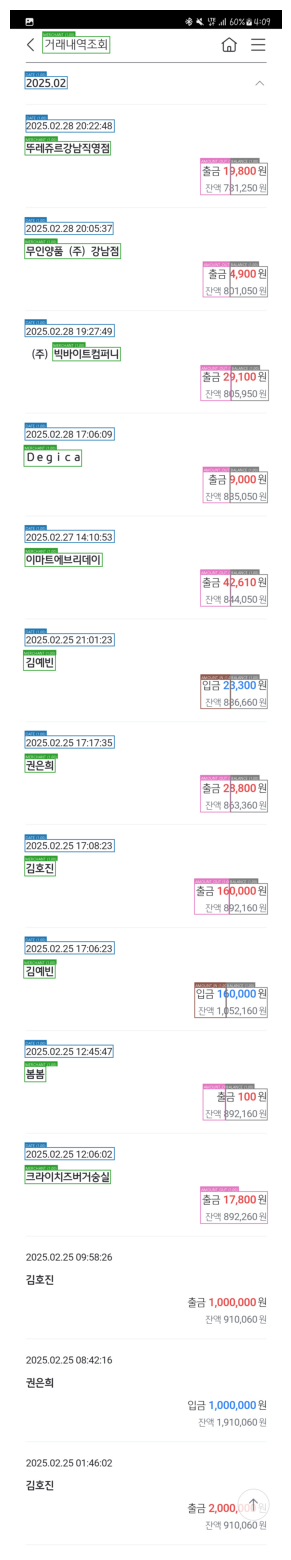


[텍스트 요약]
- MERCHANT: 거래내역조회, 뚜레쥬르강남직영점, 무인양품 (주) 강남점, 빅바이트컴퍼니, Deg i c a, 이마트에브리데이, 김예빈, 권은희, 김호진, 김예빈, 봄봄, 크라이치즈버거숭실
- DATE: 2025.02, 2025.02.28 20:22:48, 2025.02.28 20:05:37, 2025.02.28 19:27:49, 2025.02.28 17:06:09, 2025.02.27 14:10:53, 2025.02.25 21:01:23, 2025.02.25 17:17:35, 2025.02.25 17:08:23, 2025.02.25 17:06:23, 2025.02.25 12:45:47, 2025.02.25 12:06:02
- AMOUNT_OUT: 출금 19,800, 출금 4,900, 출금 29,100, 출금 9,000, 출금 42,610, 출금 28,800, 출금 160,000, 출금 100, 출금 17,800원 잔맥 892,260 원
- BALANCE: 잔액 781,250, 잔액 801,050, 잔액 805,950, 잔액 835,050, 잔액 844,050, 잔액 886,660, 잔액 863,360, 잔액 892,160, 잔액 1,052,160, 잔액 892,160
- AMOUNT_IN: 입금 23,300, 입금 160,000
--------------------------------------------------

'kabang1.jpg' 처리 시작...

--- [kabang1.jpg] 정보 추출 결과 ---


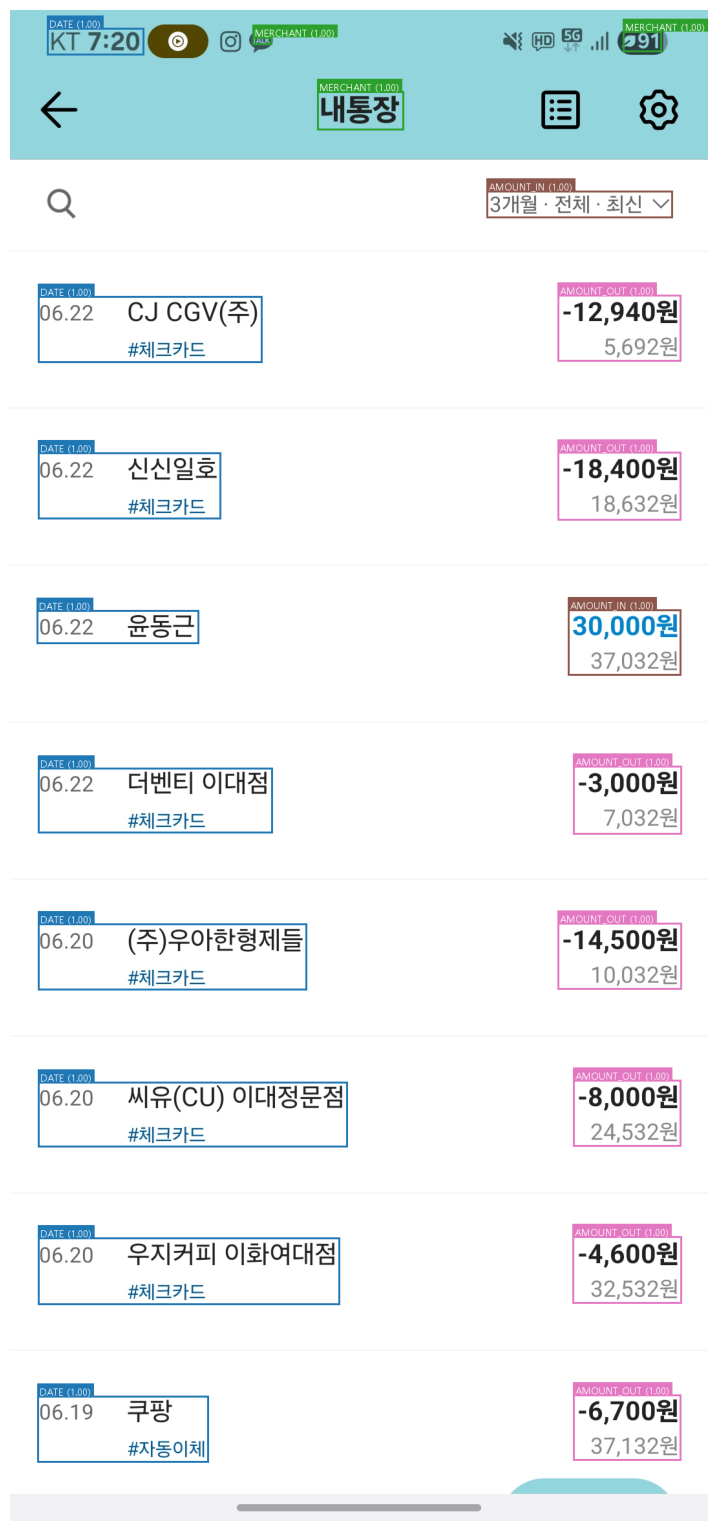


[텍스트 요약]
- DATE: KT 7:20, 06.22 CJ CGV(주) #체크카드, 06.22 신신일호 #체크카드, 06.22 윤동근, 06.22 더벤티 이대점 #체크카드, 06.20 (주)우아한형제들 #체크카드, 06.20 씨유(CU) 이대정문점 #체크카드, 06.20 우지커피 이화여대점 #체크카드, 06.19 쿠팡 #자동이체
- MERCHANT: TALK, 191, 내통장
- AMOUNT_IN: 3개월 전체 최신 V, 30,000원 37,032원
- AMOUNT_OUT: -12,940원 5,692원, -18,400원 18,632원, -3,000원 7,032원, -14,500원 10,032원, -8,000원 24,532원, -4,600원 32,532원, -6,700원 37,132원
--------------------------------------------------

'kabang2.jpg' 처리 시작...

--- [kabang2.jpg] 정보 추출 결과 ---


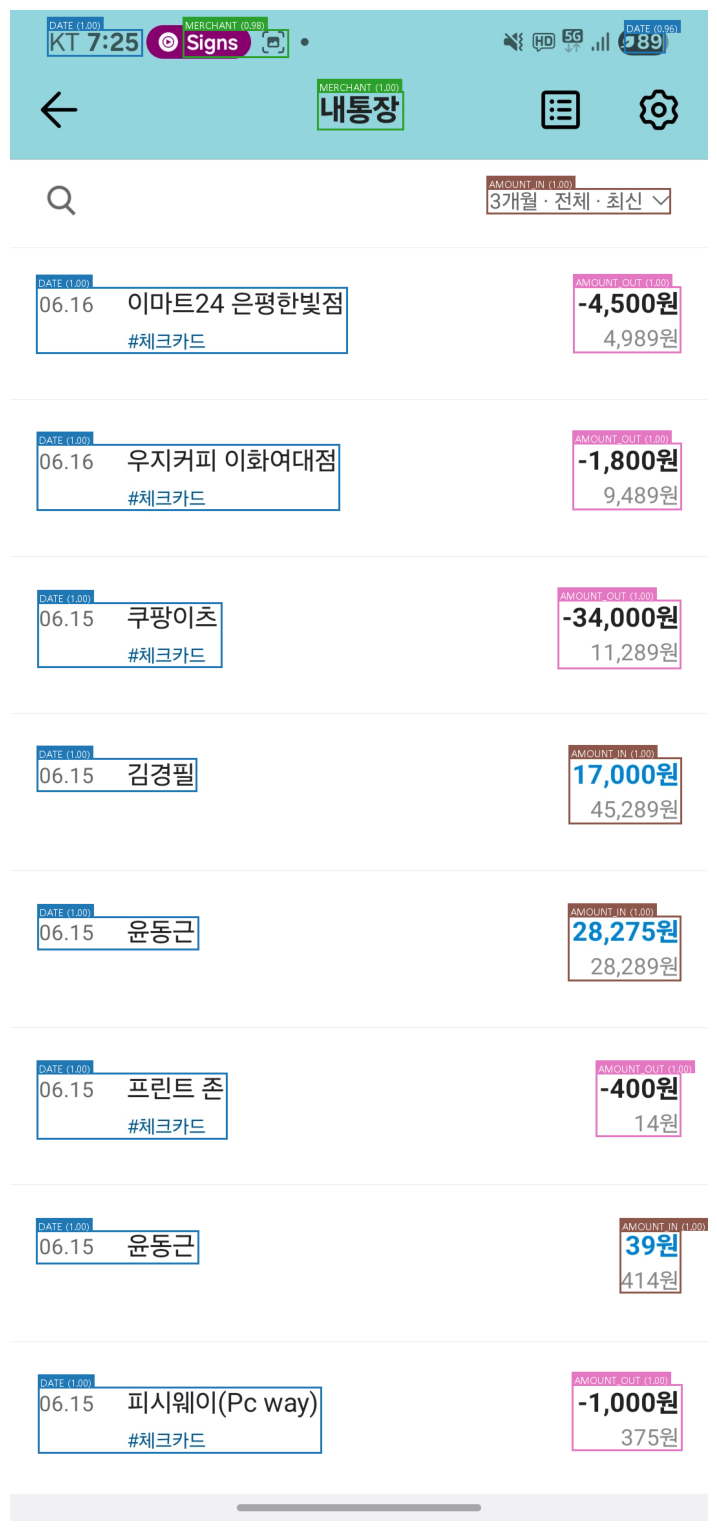


[텍스트 요약]
- DATE: KT 7:25, 789, 06.16 이마트24 은평한빛점 #체크카드, 06.16 우지커피 이화여대점 #체크카드, 06.15 쿠팡이츠 #체크카드, 06.15 김경필, 06.15 윤동근, 06.15 프린트 존 #체크카드, 06.15 윤동근, 06.15 피시웨이(Pc way) #체크카드
- MERCHANT: Signs 's), 내통장
- AMOUNT_IN: 3개월 전체 - 최신 <, 17,000원 45,289원, 28,275원 28,289원, 39원 414원
- AMOUNT_OUT: -4,500원 4,989원, -1,800원 9,489원, -34,000원 11,289원, -400원 14원, -1,000원 375원
--------------------------------------------------

'kabang3.jpg' 처리 시작...

--- [kabang3.jpg] 정보 추출 결과 ---


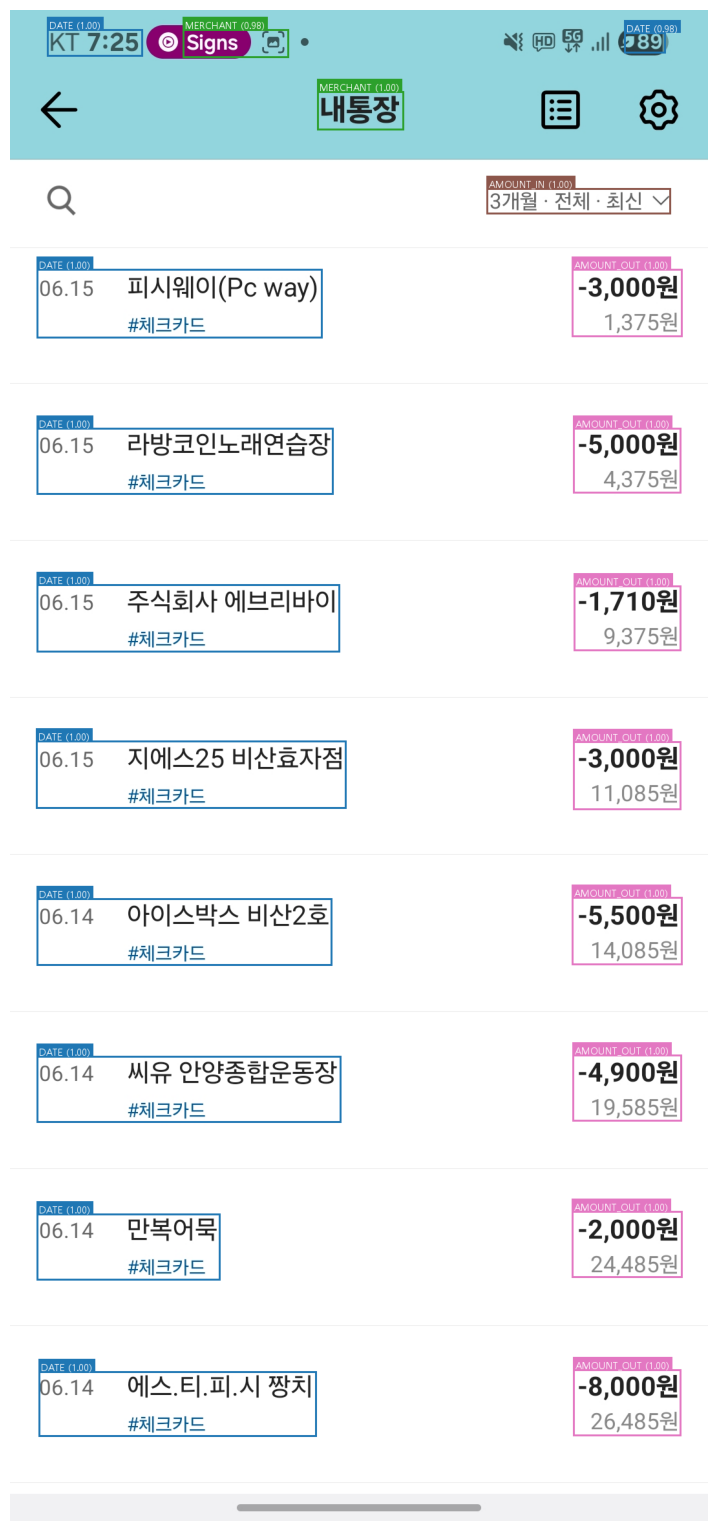


[텍스트 요약]
- DATE: KT 7:25, 789, 06.15 피시웨이(Pc way) #체크카드, 06.15 라방코인노래연습장 #체크카드, 06.15 주식회사 에브리바이 #체크카드, 06.15 지에스25 비산효자점 #체크카드, 06.14 아이스박스 비산2호 #체크카드, 06.14 씨유 안양종합운동장 #체크카드, 06.14 만복어묵 #체크카드, 06.14 에스.티.피.시 짱치 #체크카드
- MERCHANT: Signs 's), 내통장
- AMOUNT_IN: 3개월 전체 - 최신 <
- AMOUNT_OUT: -3,000원 1,375원, -5,000원 4,375원, - 1,710원 9,375원, -3,000원 11,085원, -5,500원 14,085원, -4,900원 19,585원, -2,000원 24,485원, -8,000원 26,485원
--------------------------------------------------

'kabang4.jpg' 처리 시작...

--- [kabang4.jpg] 정보 추출 결과 ---


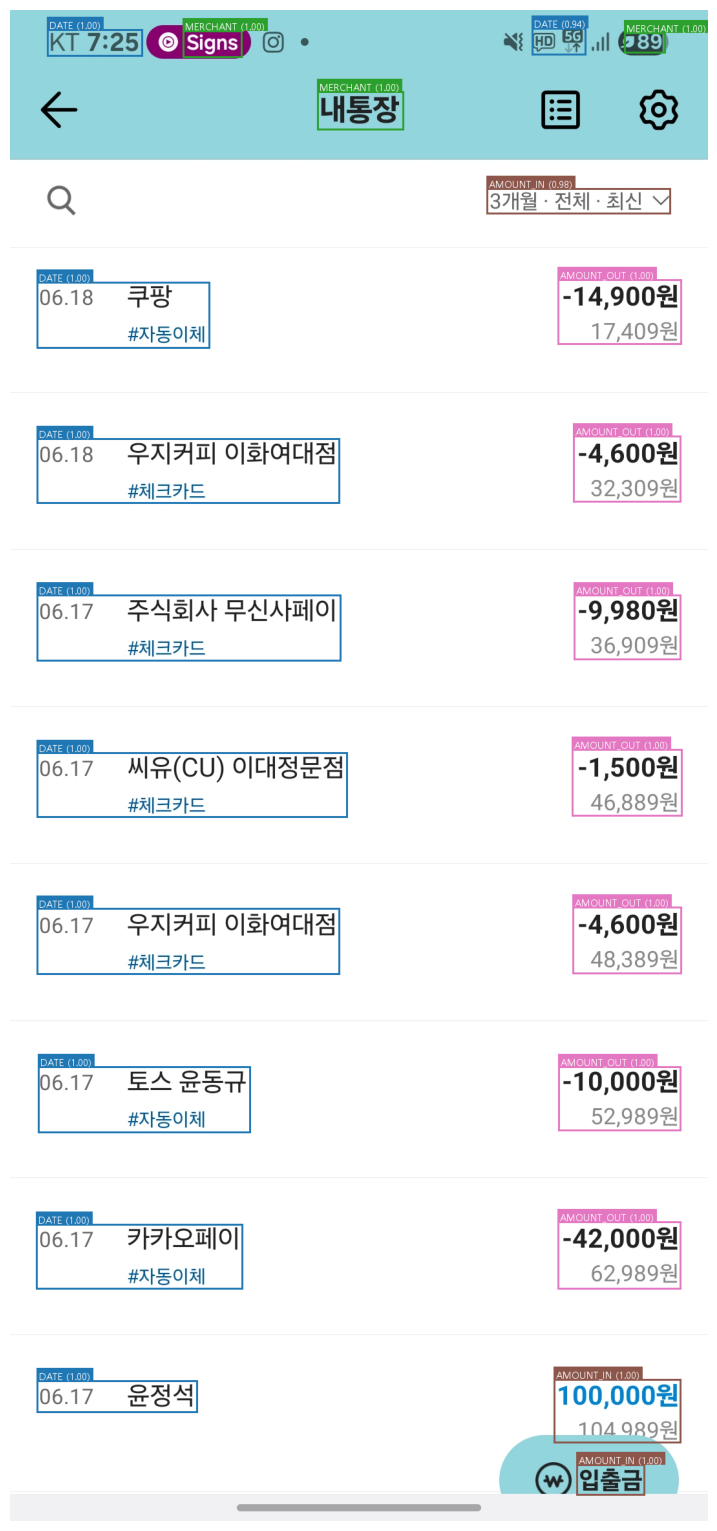


[텍스트 요약]
- DATE: KT 7:25, CD, 06.18 쿠팡 #자동이체, 06.18 우지커피 이화여대점 #체크카드, 06.17 주식회사 무신사페이 #체크카드, 06.17 씨유(CU) 이대정문점 #체크카드, 06.17 우지커피 이화여대점 #체크카드, 06.17 토스 윤동규 #자동이체, 06.17 카카오페이 #자동이체, 06.17 윤정석
- MERCHANT: Signs, 789, 내통장
- AMOUNT_IN: 3개월 전체 - 최신 <, 100,000원 104089원, 입출금
- AMOUNT_OUT: -14,900원 17,409원, -4,600원 32,309원, -9,980원 36,909원, -1,500원 46,889원, -4,600원 48,389원, -10,000원 52,989원, -42,000원 62,989원
--------------------------------------------------

'shinhan2.jpg' 처리 시작...

--- [shinhan2.jpg] 정보 추출 결과 ---


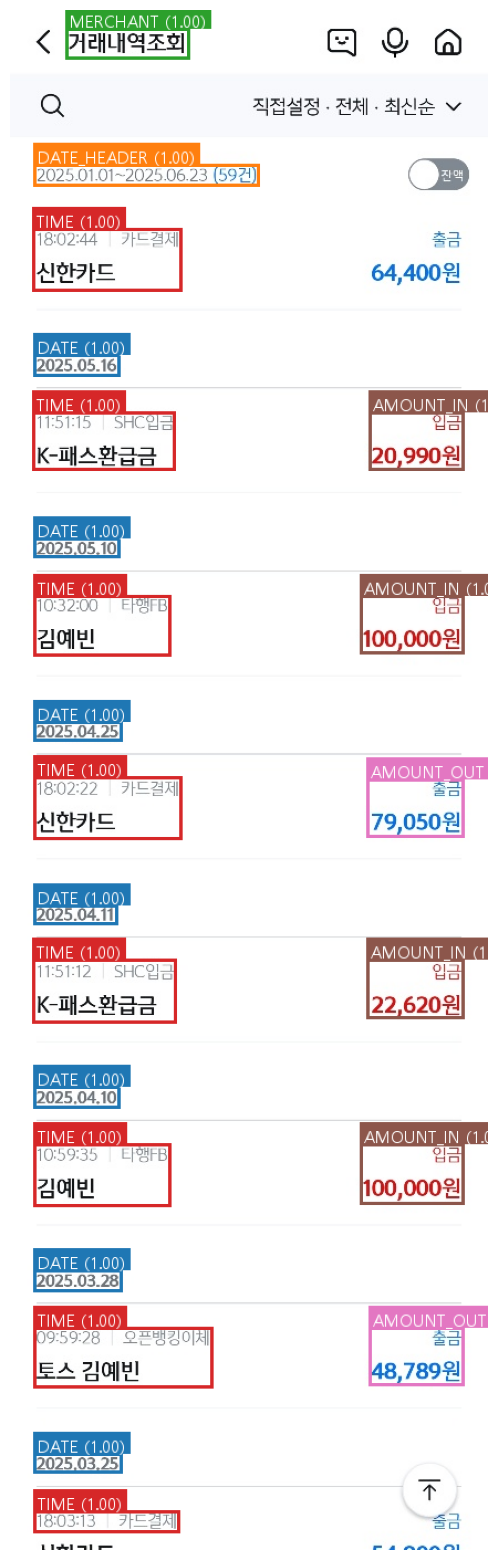


[텍스트 요약]
- MERCHANT: 거래내역조회
- DATE_HEADER: 2025.01.01~2025.06.23 (59건)
- TIME: 18:02:44 카드결세 신한카드, 11:51:15 SHC입금 K-패스환급금, 10:32:00 타행FB 김예빈, 18:02:22 카드결제 신한카드, 11:51:12 SHC입금 K-패스환급금, 10:59:35 타행FB 김예빈, 09:59:28 오픈뱅킹이체 토스 김예빈, 18:03:13 카드결제
- DATE: 2025.05.16, 2025.05.10, 2025.04.25, 2025.04.11, 2025.04.10, 2025.03.28, 2025.03.25
- AMOUNT_IN: 입금 20,990원, 입금 100,000원, 입금 22,620원, 입금 100,000원
- AMOUNT_OUT: 출금 79,050원, 출금 48,789원
--------------------------------------------------

'shinhan3.jpg' 처리 시작...

--- [shinhan3.jpg] 정보 추출 결과 ---


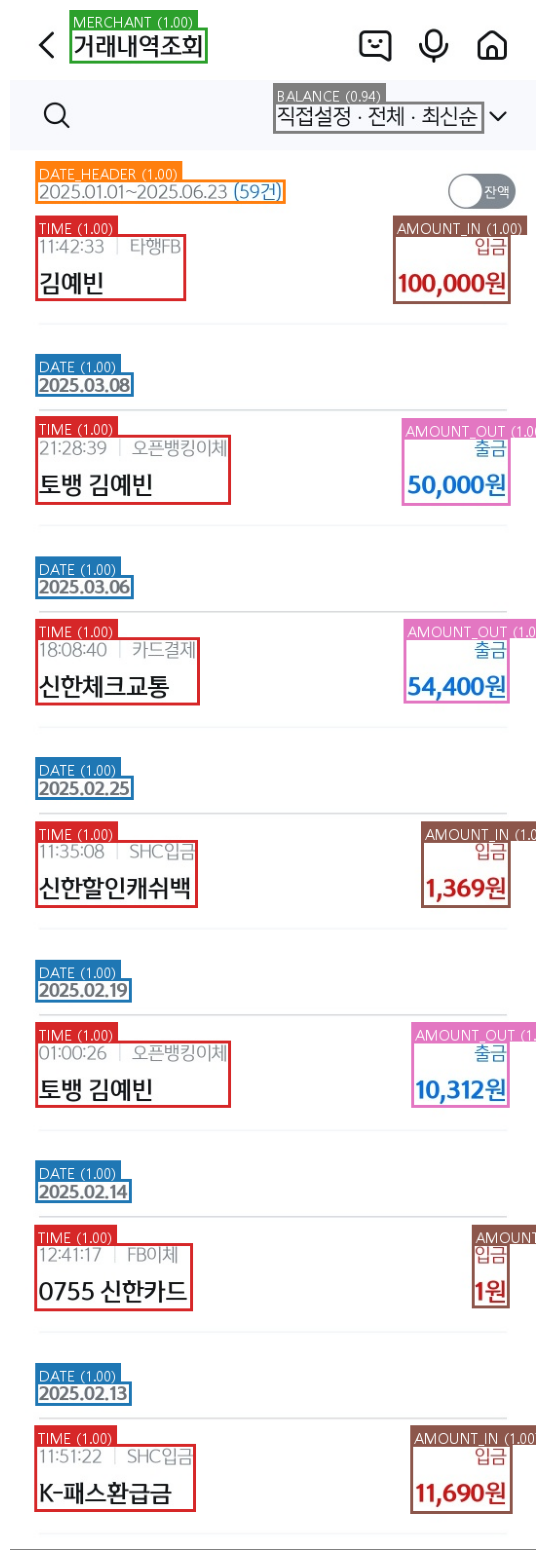


[텍스트 요약]
- MERCHANT: 거래내역조회
- BALANCE: 직접설정 - 전체 - 최신순
- DATE_HEADER: 2025.01.01~2025.06.23 (59건)
- TIME: 11:42:33 타행FB 김예빈, 21:28:39 오픈뱅킹이체 토뱅 김예빈, 18:08:40 카드결제 신한체크교통, 11:35:08 SHC입금 신한할인캐쉬백, 01:00:26 오픈뱅킹이체 토뱅 김예빈, 12:41:17 FB이체 0755 신한카드, 11:51:22 SHC입금 K-패스환급금
- AMOUNT_IN: 입금 100,000원, 입금 1,369원, 입금 1원, 입금 11,690원
- DATE: 2025.03.08, 2025.03.06, 2025.02.25, 2025.02.19, 2025.02.14, 2025.02.13
- AMOUNT_OUT: 출금 50,000원, 출금 54,400원, 출금 10,312원
--------------------------------------------------

'shinhan4.jpg' 처리 시작...

--- [shinhan4.jpg] 정보 추출 결과 ---


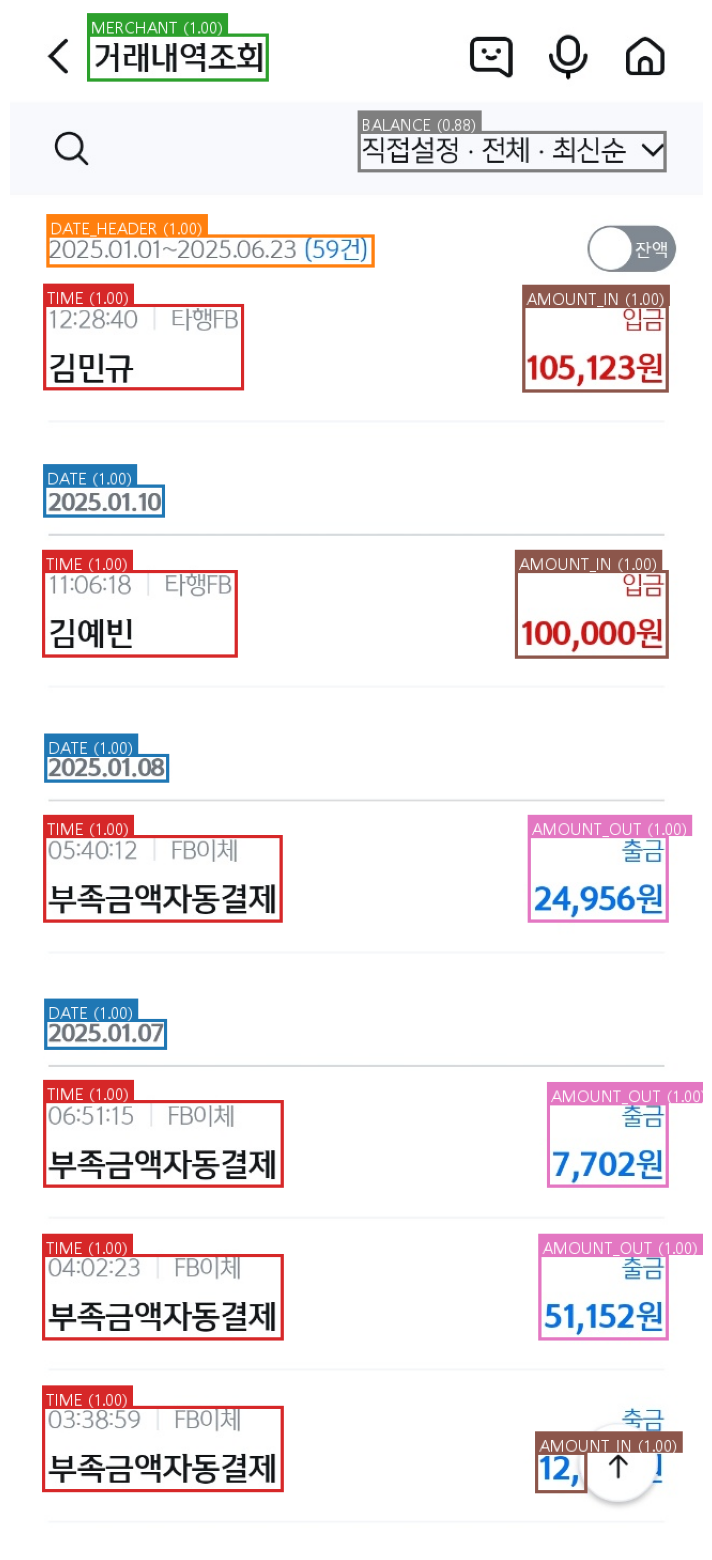


[텍스트 요약]
- MERCHANT: 거래내역조회
- BALANCE: 직접설정 전체 최신순 L
- DATE_HEADER: 2025.01.01~2025.06.23 (59건)
- TIME: 12:28:40 타행FB 김민규, 11:06:18 타행FB 김예빈, 05:40:12 FB이체 부족금액자동결제, 06:51:15 FB이체 부족금액자동결제, 04:02:23 FB이체 부족금액자동결제, 03:38:59 FB이체 부족금액자동결제
- AMOUNT_IN: 입금 105,123원, 입금 100,000원, 12,
- DATE: 2025.01.10, 2025.01.08, 2025.01.07
- AMOUNT_OUT: 출금 24,956원, 출금 7,702원, 출금 51,152원
--------------------------------------------------


In [4]:
import matplotlib.pyplot as plt

# --- 1. 설정 ---
# 테스트할 이미지가 있는 폴더
TEST_IMAGE_DIR = '../bank_statement_test'
TEST_IMAGE_DIR2 = '../bank_statement'
# 사용할 폰트 경로 (None으로 두면 시스템 기본 폰트 또는 'malgun.ttf' 시도)
FONT_PATH = None 

# --- 2. 예측기 초기화 ---
try:
    predictor = AdvancedDocumentPredictor(model_path=OUTPUT_DIR)
except Exception as e:
    print(f"예측기 초기화 실패: {e}")
    # Stop execution if predictor fails
    raise

# --- 3. 이미지 예측 및 결과 출력 ---
test_image_files = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.png')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg')) + \
                    glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.png')) + \
                    glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.jpg'))

if not test_image_files:
    print(f"오류: '{TEST_IMAGE_DIR}' 폴더에서 테스트 이미지를 찾을 수 없습니다.")
else:
    for image_path in test_image_files:
        # 예측 수행
        predictions, image = predictor.predict(image_path)
        
        # 결과 시각화
        result_image = draw_predictions(image.copy(), predictions, font_path=FONT_PATH)
        
        # 결과 출력 (이미지 및 텍스트)
        print(f"\n--- [{os.path.basename(image_path)}] 정보 추출 결과 ---")
        plt.figure(figsize=(9, 20))
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()
        
        print("\n[텍스트 요약]")
        if predictions:
            # 보기 좋게 라벨별로 묶어서 출력
            summary = {}
            for p in predictions:
                label = p['label']
                if label not in summary:
                    summary[label] = []
                summary[label].append(p['text'])
            
            for label, texts in summary.items():
                print(f"- {label}: {', '.join(texts)}")
        else:
            print("추출된 정보가 없습니다.")
        print("-" * 50)